In [1]:
from __future__ import annotations

from IPython.display import Markdown as md
from IPython.display import display, HTML

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from typing import Literal, Union, List, Optional, Sequence, Tuple, Callable, Any, Dict
from scipy.stats import chi2_contingency
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import sys
import gc
import os

In [2]:
drive.mount("/content/drive/")
%cd "drive/MyDrive/DABI 2"

Mounted at /content/drive/
/content/drive/MyDrive/DABI 2


In [ ]:
def process_data_by_chunks(
        orders_path: str,
        orders_products_path: str,
        output_chunk_dir: str,
        percentage_per_chunk: float
) -> None:
    os.makedirs(output_chunk_dir, exist_ok=True)

    orders_df_for_ids = pd.read_parquet("orders.parquet", columns=['user_id'])
    unique_user_ids = sorted(orders_df_for_ids['user_id'].unique())

    del orders_df_for_ids
    gc.collect()

    print(f"Found {len(unique_user_ids)} unique `user_ids` in total.")

    num_users = len(unique_user_ids)
    users_per_chunk = max(1, int(num_users * percentage_per_chunk))
    user_id_chunks_sets = []

    for i in range(0, num_users, users_per_chunk):
        user_id_chunks_sets.append(set(unique_user_ids[i:i + users_per_chunk]))

    print(f"Define {len(user_id_chunks_sets)} user chunks with approx. {percentage_per_chunk * 100}% of users per chunk.")

    orders_products_read_chunk_size = 500000

    parquet_orders_reader = pq.ParquetFile(orders_path)

    for i, target_user_ids_set in enumerate(user_id_chunks_sets):
        current_chunk_number = i + 1
        print(f"\n--- Computing user chunk {current_chunk_number}/{len(user_id_chunks_sets)} ---")

        chunk_orders_data = []
        num_orders_row_groups = parquet_orders_reader.num_row_groups

        for rg_idx in range(num_orders_row_groups):
            rg_table = parquet_orders_reader.read_row_group(rg_idx, columns=["user_id", "order_id", "order_date"])
            rg_df = rg_table.to_pandas()

            filtered_orders_chunk = rg_df[rg_df.user_id.isin(target_user_ids_set)]
            if not filtered_orders_chunk.empty:
                chunk_orders_data.append(filtered_orders_chunk)

            del rg_df, rg_table
            gc.collect()

        if not chunk_orders_data:
            print(f"Could not find `orders` data for user chunk {current_chunk_number}. Skipping.")
            continue

        current_orders_df = pd.concat(chunk_orders_data, ignore_index=True)

        del chunk_orders_data
        gc.collect()

        print(f"\t- No. loaded `orders` for this chunk: {len(current_orders_df)} rows.")

        target_order_ids_for_chunk = set(current_orders_df.order_id.unique())

        chunk_orders_products_data = []
        for op_chunk_pd in pd.read_csv(orders_products_path, chunksize=orders_products_read_chunk_size):
            filtered_op_chunk = op_chunk_pd[op_chunk_pd.order_id.isin(target_orflofloatsadasdasdder_ids_for_chunk)]ccycadfadadsadasd


            dadadasdasdasdadasdasddsaasddasasdasdasd                             asdasdadasdadasddddddsdsdsdy

            if not filtered_op_chunk.empty:
                chunk_orders_products_data.append(filtered_op_chunk)

            del op_chunk_pd
            gc.collect()

        final_merged_chunk_df = None

        if chunk_orders_products_data:
            current_orders_products_df = pd.concat(chunk_orders_products_data, ignore_index=True)

            del chunk_orders_products_data
            gc.collect()

            print(f"  - No. loaded `orders_products` for this chunk: {len(current_orders_products_df)} rows.")

            print(f"  - Merging `orders` ({len(current_orders_df)} rows) with `orders_products` ({len(current_orders_products_df)} rows)...")
            final_merged_chunk_df = current_orders_df.merge(current_orders_products_df, on="order_id")

            del current_orders_products_df
            gc.collect()
        else:
            print(f"  - No 'orders_products' data for user chunk {current_chunk_number} has been found. Procceding with `orders` data.")
            final_merged_chunk_df = current_orders_df

        output_filepath = os.path.join(output_chunk_dir, f"{current_chunk_number}_orders_products_user_chunk.parquet")
        final_merged_chunk_df.to_parquet(output_filepath, index=False)
        print(f"  - Chunk {current_chunk_number} stored in {output_filepath}")

        del final_merged_chunk_df
        del current_orders_df
        gc.collect()

        print(f"  - Shared location for chunk {current_chunk_number}.")

    print("\nDone! All user chunks have been computed and stored.")

In [ ]:
process_data_by_chunks("orders.parquet", "order_products_denormalized.csv", "chunks", 0.1)

Insgesamt 62032 eindeutige user_ids gefunden.
Definiert 11 Benutzer-Chunks mit ca. 10.0% der Benutzer pro Chunk.

--- Verarbeite Benutzer-Chunk 1/11 ---
	- Geladene 'orders' für diesen Chunk: 144344 Zeilen.
  - Geladene 'orders_products' für diesen Chunk: 1455733 Zeilen.
  - Merging 'orders' (144344 Zeilen) mit 'orders_products' (1455733 Zeilen)...
  - Chunk 1 gespeichert unter chunks/1_orders_products_user_chunk.parquet
  - Speicher für Chunk 1 freigegeben.

--- Verarbeite Benutzer-Chunk 2/11 ---
	- Geladene 'orders' für diesen Chunk: 146408 Zeilen.
  - Geladene 'orders_products' für diesen Chunk: 1493637 Zeilen.
  - Merging 'orders' (146408 Zeilen) mit 'orders_products' (1493637 Zeilen)...
  - Chunk 2 gespeichert unter chunks/2_orders_products_user_chunk.parquet
  - Speicher für Chunk 2 freigegeben.

--- Verarbeite Benutzer-Chunk 3/11 ---
	- Geladene 'orders' für diesen Chunk: 147328 Zeilen.
  - Geladene 'orders_products' für diesen Chunk: 1506954 Zeilen.
  - Merging 'orders' (147328

In [3]:
orders = pd.read_parquet("orders.parquet")
tip_temp = pd.read_csv("tip_testdaten_template_V2.csv", usecols=["order_id", "tip"])
tips = pd.read_csv("tips_public.csv", usecols=["order_id", "tip"])

In [4]:
tips["tip"] = tips.tip.astype(int)
orders_tips = orders.merge(tips).sort_values(["user_id", "order_date"])  # Merging of order data and tip data

In [ ]:
def df_to_table(
        df: pd.DataFrame,
        columns: Optional[Union[pd.Index, Sequence]] = None,
        display_index: Optional[bool] = True,
        index: Optional[Union[pd.Index, Sequence]] = None,
        round_floats: Optional[int] = None
) -> HTML:
    cols = columns if columns is not None else df.columns
    idx = index if index is not None else df.index

    table_head = "<tr>"
    if display_index:
        table_head += '<th style="border: 1px solid #999;"></th>'
    table_head += "".join(f'<th style="border: 1px solid #999;">{col}</th>' for col in cols)
    table_head += "</tr>"

    table_body = ""
    for i, row in enumerate(df.itertuples(index=False)):
        table_body += "<tr>"
        if display_index:
            table_body += f'<td style="border: 1px solid #999;">{idx[i]}</td>'
        for val in row:
            if isinstance(val, float) and round_floats is not None:
                val = round(val, round_floats)
            table_body += f'<td style="border: 1px solid #999;">{val}</td>'
        table_body += "</tr>"

    html_output = f"""
    <style>
        .styled-table {{
            border-collapse: collapse;
            font-family: sans-serif;
            font-size: 14px;
        }}
        .styled-table tr:nth-child(even) {{
            background-color: #727272;
        }}
        .styled-table th, .styled-table td {{
            padding: 8px 12px;
            border: 1px solid #999;
            text-align: left;
        }}
    </style>
    <table class="styled-table">
        {table_head}
        {table_body}
    </table>
    """

    return HTML(html_output)

In [ ]:
def train_ar(X: pd.DataFrame, lags: int) -> float:
    """
    Trains and evaluates an Autoregressive (AR) model to predict users' tip probability
    based on historical tipping behavior.

    This function prepares the input data by creating lagged tip features,
    encodes user IDs, and performs time-series cross-validation to
    robustly evaluate model performance.

    Args:
        X (pd.DataFrame): Input DataFrame containing 'order_date', 'user_id', and 'tip' data.
                          'tip' is expected to be a binary (0 or 1) target variable.
        lags (int): The number of historical orders (lags) to include as features
                    in the autoregressive model (e.g., 1 for AR(1), 2 for AR(2)).

    Returns:
        float: The mean accuracy across all cross-validation folds,
               indicating the model's performance in predicting tip probability.
    """
    # Create a copy of the DataFrame and select only the necessary columns
    # to avoid modifying the original DataFrame and reduce memory footprint.
    X_processed = X.copy()[["order_date", "user_id", "tip"]]

    # Sort data by user and then by order date to ensure correct lagging.
    X_processed.sort_values(["order_date", "user_id"], inplace=True)
    # Set 'order_date' as the index for time-series operations,
    # though TimeSeriesSplit primarily relies on positional indexing.
    X_processed.set_index("order_date", inplace=True)

    # Generate shifted tip features. For each lag, create a new column
    # showing the tip status from a previous order for the same user.
    for lag in range(1, lags + 1):
        X_processed[f"tip_t-{lag}"] = X_processed.groupby("user_id").tip.shift(lag)

    # Drop rows that contain NaN values introduced by the shifting operation.
    X_processed.dropna(inplace=True)

    # Separate the target variable 'tip' from the features.
    y = X_processed.pop("tip")

    # Define the preprocessing steps for the features.
    preprocessor = ColumnTransformer(
        transformers=[
            ("user_encoder", OneHotEncoder(handle_unknown="ignore"), ["user_id"])
        ],
        remainder="passthrough"
    )

    # Initialize TimeSeriesSplit for robust cross-validation on time-series data.
    # This ensures that validation data always comes *after* training data chronologically,
    # preventing data leakage from the future.
    tscv = TimeSeriesSplit(n_splits=5)
    fold_scores = [] # List to store accuracy for each fold.

    # Iterate through each fold generated by TimeSeriesSplit.
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_processed)):
        print(f"------------ Fold {i + 1} ------------")
        print(f"Range of train indices: {len(train_idx)}, Start: {train_idx[0]}, Stop: {train_idx[-1]}")
        print(f"Range of test indices: {len(test_idx)}, Start: {test_idx[0]}, Stop: {test_idx[-1]}")

        # Split data into training and test sets based on TimeSeriesSplit indices.
        X_train, X_test = X_processed.iloc[train_idx], X_processed.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the preprocessor on the training data and transform both train/test sets.
        preprocessor.fit(X_train)
        X_train_transformed = preprocessor.transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)

        # Initialize and train the Logistic Regression model with built-in cross-validation.
        # 'cv=5' for internal CV, 'n_jobs=-1' to use all available CPU cores,
        # 'max_iter=1000' for convergence.
        model = LogisticRegressionCV(cv=5, n_jobs=-1, max_iter=1000)
        model.fit(X_train_transformed, y_train)

        # Make predictions on the transformed test set.
        y_pred = model.predict(X_test_transformed)

        # Calculate accuracy for the current fold and append to the list.
        accuracy = accuracy_score(y_test, y_pred)
        fold_scores.append(accuracy)
        print(f"Accuracy for fold {i + 1}: {accuracy:.4f}\n")

    # Return the average accuracy across all cross-validation folds.
    return np.mean(fold_scores)

In [ ]:
acc_ar_1 = train_ar(orders_tips, 1)
acc_ar_2 = train_ar(orders_tips, 2)
df_performance = pd.DataFrame({"Accuracy": [acc_ar_1, acc_ar_2]}, index=["AR(1)", "AR(2)"])

------------ Fold 1 ------------
Range of train indices: 223263, Start: 0, Stop: 223262
Range of test indices: 223261, Start: 223263, Stop: 446523
Accuracy for fold 1: 0.7342

------------ Fold 2 ------------
Range of train indices: 446524, Start: 0, Stop: 446523
Range of test indices: 223261, Start: 446524, Stop: 669784
Accuracy for fold 2: 0.7388

------------ Fold 3 ------------
Range of train indices: 669785, Start: 0, Stop: 669784
Range of test indices: 223261, Start: 669785, Stop: 893045
Accuracy for fold 3: 0.7314

------------ Fold 4 ------------
Range of train indices: 893046, Start: 0, Stop: 893045
Range of test indices: 223261, Start: 893046, Stop: 1116306
Accuracy for fold 4: 0.7311

------------ Fold 5 ------------
Range of train indices: 1116307, Start: 0, Stop: 1116306
Range of test indices: 223261, Start: 1116307, Stop: 1339567
Accuracy for fold 5: 0.7314

------------ Fold 1 ------------
Range of train indices: 212926, Start: 0, Stop: 212925
Range of test indices: 2129

In [ ]:
df_performance

,Accuracy
AR(1),0.733377
AR(2),0.741966


In [ ]:
display(df_to_table(df_performance, round_floats=4))
md(
    f"**Interpretation**\
    \nAs it is apparent, the current AR model will correctly classify the user's tip behavior for their next order in about $ {acc_ar_1 * 100:.2f}\% $ of all\
    cases, given the information about whether or not they tipped on their previous order. If this model, however, were to be given information regarding\
    the users' tip behaviors for their most recent two orders, it will classify about $ {acc_ar_2 * 100:.2f}\% $ of all users' tip behavior for their next order correctly.\
    \nNow begs the question, how far we can go back in our customers' order history, in order to make our predictions more accurate. The answer lies within the behavioral\
    patterns of our customers' tipping behaviors. In order to understand these, we will analyze and interpret the (partial) autocorrelations of our data at hand."
)

,F1 score
AR(1),0.7509
AR(2),0.7617


**Interpretation**    
As it is apparent, the current AR model will correctly classify the user's tip behavior for their next order in about $ 75.09\% $ of all    cases, given the information about whether or not they tipped on their previous order. If this model, however, were to be given information regarding    the users' tip behaviors for their most recent two orders, it will classify about $ 76.17\% $ of all users' tip behavior for their next order correctly.    
Now begs the question, how far we can go back in our customers' order history, in order to make our predictions more accurate. The answer lies within the behavioral    patterns of our customers' tipping behaviors. In order to understand these, we will analyze and interpret the (partial) autocorrelations of our data at hand.

In [ ]:
def compute_acf_improved(df: pd.DataFrame, lags: int) -> pd.Series:
    """
    Computes the autocorrelation function (ACF) for the tips of each user.

    Args:
        df (pd.DataFrame): DataFrame containing at least the colums 'tip' and
                            'user_id'.
        lags (int): The number of historical orders (lags) to include as features
                    in the autoregressive model.

    Returns:
        pd.Series: Series containing the autocorrelation coefficients
    """
    df_copy = df.copy()

    # Generate shifted features
    for lag_val in range(1, lags + 1):
        df_copy[f"tip_t-{lag_val}"] = df_copy.groupby("user_id").tip.shift(lag_val)

    df_copy.dropna(inplace=True)

    # Only select tip column and the shifted features for computation
    cols_to_correlate = ["tip"] + [f"tip_t-{lag_val}" for lag_val in range(1, lags + 1)]

    final_df = df_copy[df_copy.columns.intersection(cols_to_correlate)]

    # Compute correlation
    acf_results = final_df.corr()["tip"]

    # Drop row with index "tip" as it is redundant
    # Rename indexes to address data points via their corresponding lag
    return acf_results.drop("tip").rename(index=lambda x: int(x.split('-')[1]))


def compute_pacf_improved(df: pd.DataFrame, lags: int) -> dict:
    """
    Compute the partial autocorrelation function (PACF) per user.
    Lags are created on users' base to avoid computation across
    "user limits".

    Args:
        df (pd.DataFrame): DataFrame containing at least the colums 'tip' and
                            'user_id'.
        lags (int): The number of historical orders (lags) to include as features
                    in the autoregressive model.

    Returns:
        dict: A dictionary containing the PACF coefficients
    """
    df_copy = df.copy()
    df_copy.sort_values(["user_id", "order_date"], inplace=True)

    # Generate shifted features
    for l in range(1, lags + 1):
        df_copy[f"tip_t-{l}"] = df_copy.groupby("user_id").tip.shift(l)

    df_copy.dropna(inplace=True)

    pacf_vals = {}

    for lag in range(1, lags + 1):
        if lag == 1:
            # PACF(1) = ACF(1)
            corr_val = df_copy["tip"].corr(df_copy['tip_t-1'])
            if not np.isnan(corr_val):
                pacf_vals[lag] = corr_val
        else:
            # For PACF(k) regress Y_t on Y_{t-1}, ..., Y_{t-k+1}
            # and Y_{t-k} on Y_{t-1}, ..., Y_{t-k+1}
            # Then, correlate residuals
            X_prime_cols = [f"tip_t-{l}" for l in range(1, lag)]

            required_cols = ["tip", f"tip_t-{lag}"] + X_prime_cols

            # Select relevant columns only
            subset_for_lag = df_copy[df_copy.columns.intersection(required_cols)]

            # Sicherstellen, dass subset_for_lag nicht leer ist nach intersection
            if subset_for_lag.empty or len(subset_for_lag) < 2:  # Mindestens 2 Punkte für Korrelation
                pacf_vals[lag] = np.nan  # Keine Berechnung möglich
                continue

            # Regression von Y_t auf Y_{t-1}, ..., Y_{t-k+1}
            model_y = LinearRegression()
            model_y.fit(subset_for_lag[X_prime_cols], subset_for_lag["tip"])
            residuals_y = subset_for_lag["tip"] - model_y.predict(subset_for_lag[X_prime_cols])

            # Regression von Y_{t-k} auf Y_{t-1}, ..., Y_{t-k+1}
            model_xk = LinearRegression()
            model_xk.fit(subset_for_lag[X_prime_cols], subset_for_lag[f"tip_t-{lag}"])
            residuals_xk = subset_for_lag[f"tip_t-{lag}"] - model_xk.predict(subset_for_lag[X_prime_cols])

            # Korrelation der Residuen
            # Muss nan-Werte handhaben, falls sie durch die Regression entstehen
            # np.corrcoef handhabt NaN, gibt NaN zurück, wenn alle nan sind
            correlation = np.corrcoef(residuals_y, residuals_xk)[0, 1]
            if not np.isnan(correlation):
                pacf_vals[lag] = correlation
            else:
                pacf_vals[lag] = np.nan  # Falls Korrelation NaN ist

    return pacf_vals

As previously mentioned, we'll make use of the autocorrelation function (ACF) and the partial autocorrelation function (PACF), in order to understand
behavioral patterns in tipping across our customers. These metrics help us analyze how much past events (previous tips) influence current tipping behavior.

---
### What the functions do
1. `compute_acf`: This function calculates the raw correlations between the current tip value (`tip_t`) and its lagged versions (e.g., `tip_t-1`, `tip_t-2`,
$\dots$). It does so separately for each user and then combines the results to compute the overall correlation matrix.
- The ACF answers:
>"How much does tipping today relate to tipping $1$, $2$, $\dots$, $k$ steps ago?"
2. `compute_pacf`: This function calculates the direct effect of a previous tip
(e.g., `tip_t-k`) on the current tip (`tip_t`) while controlling for the intermediate lags (`tip_t-1` to `tip_t-k+1`).
- For lag $1$, it simply computes the direct correlation between `tip` and `tip_t-1` (i.e. the ACF).
- For higher lags, it uses a linear regression model to isolate the residual part of the current tip and then calculates how much that residual still correlates with `tip_t-k`.
- PACF answers:
>"Does tipping two (or more) steps ago have a direct influence on current tipping - beyond what can be explained by more recent behavior?"

---
### Why this matters
- ACF and PACF give us insight into behavioral dependencies over time:
    - A high lag $1$ PACF would suggest habitual tipping behavior (e.g., users who tipped last time tend to tip again).
    - A low or negative lag $2+$ PACF might suggest reacionary behavior or that tipping decisions are not strongly dependent on older history.
- These insights help us:
    - Better model user behavior in prediction tasks
    - Understand the memory effect in customer actions
    - Identify opportunities for intervention (e.g., personalized nudges for users who previously tipped)

In [ ]:
acf = compute_acf_improved(orders_tips, 10)
pacf = compute_pacf_improved(orders_tips, 10)

In [ ]:
pacf

{1: np.float64(0.4589361534314325),
 2: np.float64(0.2336097673439864),
 3: np.float64(0.17548776559700544),
 4: np.float64(0.1440740969825668),
 5: np.float64(0.1191018616551626),
 6: np.float64(0.10383451070207256),
 7: np.float64(0.08997403679081724),
 8: np.float64(0.08224974773295454),
 9: np.float64(0.07258165082121364),
 10: np.float64(0.06694395205541036)}

In [ ]:
df_acf = pd.DataFrame({"Lag": acf.index, "ACF": acf.values}).iloc[1:]

In [ ]:
def plot_corr(df: pd.DataFrame, func: Literal["ACF", "PACF"], title: str) -> None:
    fig = go.Figure()

    # 1. Vertikale Linien
    for i, row in df.iterrows():
        fig.add_trace(go.Scatter(
            x=[row["Lag"], row["Lag"]],
            y=[0, row[func]],
            mode="lines",
            line=dict(color='blue', width=1),
            showlegend=False
        ))

    # 2. Punkte
    fig.add_trace(go.Scatter(
        x=df["Lag"],
        y=df[func],
        mode="markers",
        marker=dict(size=8, color='blue'),
        name="Coefficient"
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title="Lag",
        xaxis_type="category",
        yaxis_title=func,
        template="plotly_dark"
    )

    fig.show()
    fig.write_html(f"{func.lower()}.html")

In [ ]:
plot_corr(df_acf, "ACF", "Autocorrelation Function for 10 lags")

In [ ]:
plot_corr(pd.DataFrame({"Lag": pacf.keys(), "PACF": pacf.values()}), "PACF", "Partial Autocorrelation Function for 10 lags")

In [ ]:
acc_ar_3 = train_ar(orders_tips, 3)
acc_ar_4 = train_ar(orders_tips, 4)

df_performance.loc["AR(3)"] = acc_ar_3
df_performance.loc["AR(4)"] = acc_ar_4

------------ Fold 1 ------------
Range of train indices: 202584, Start: 0, Stop: 202583
Range of test indices: 202584, Start: 202584, Stop: 405167
Accuracy for fold 1: 0.7383

------------ Fold 2 ------------
Range of train indices: 405168, Start: 0, Stop: 405167
Range of test indices: 202584, Start: 405168, Stop: 607751
Accuracy for fold 2: 0.7413

------------ Fold 3 ------------
Range of train indices: 607752, Start: 0, Stop: 607751
Range of test indices: 202584, Start: 607752, Stop: 810335
Accuracy for fold 3: 0.7367

------------ Fold 4 ------------
Range of train indices: 810336, Start: 0, Stop: 810335
Range of test indices: 202584, Start: 810336, Stop: 1012919
Accuracy for fold 4: 0.7391

------------ Fold 5 ------------
Range of train indices: 1012920, Start: 0, Stop: 1012919
Range of test indices: 202584, Start: 1012920, Stop: 1215503
Accuracy for fold 5: 0.7392

------------ Fold 1 ------------
Range of train indices: 193530, Start: 0, Stop: 193529
Range of test indices: 1935

In [ ]:
df_performance

,Accuracy
AR(1),0.733377
AR(2),0.741966
AR(3),0.738908
AR(4),0.742509


In [ ]:
display(df_to_table(df_performance, round_floats=4))

md(
    f"**Interpretation**\
    \nConsidering that our current main objective is to improve an AR model, our results are rather untypical for an AR-process.\
    \nThe ACF of an AR process usually shows a cutoff, which we don't seem to have in this case. Typically, we'd expect an exponential\
    or a geometrical decrease of the correlation coefficients. Instead, we are presented a persistant, high correlation across all lags.\
    This might indicate that we are could be dealing with trend-based data.\
    \nThe PACF plot is what helps us determine which order might be the best fit for our AR model. The most notable cutoff is occurring\
    for a lag of $2$, however, the lags $3$ and $4$ might be a good fit for our model, too. Any other lag beyond $4$ doesn't seem to\
    be providing plenty of additional information.\
    \n\n---\
    \nAccuracy of $AR(3)\colon{(acc_ar_3 * 100):.2f}\%$; Accuracy of $AR(4)\colon{(acc_ar_4 * 100):.2f}\%$\
    \nThus, an AR({ {acc_ar_3: 3, acc_ar_4: 4}[max(acc_ar_3, acc_ar_4)]}) model seems to be the best choice, at least for now."
)

,Accuracy
AR(1),0.7334
AR(2),0.742
AR(3),0.7389
AR(4),0.7425


**Interpretation**    
Considering that our current main objective is to improve an AR model, our results are rather untypical for an AR-process.    
The ACF of an AR process usually shows a cutoff, which we don't seem to have in this case. Typically, we'd expect an exponential    or a geometrical decrease of the correlation coefficients. Instead, we are presented a persistant, high correlation across all lags.    This might indicate that we are could be dealing with trend-based data.    
The PACF plot is what helps us determine which order might be the best fit for our AR model. The most notable cutoff is occurring    for a lag of $2$, however, the lags $3$ and $4$ might be a good fit for our model, too. Any other lag beyond $4$ doesn't seem to    be providing plenty of additional information.    

---    
Accuracy of $AR(3)\colon73.89\%$; Accuracy of $AR(4)\colon74.25\%$    
Thus, an AR(4) model seems to be the best choice, at least for now.

## Trend- und Periodizitätenbereinigung

In [ ]:
otc = orders_tips.copy()
otc.sort_values("order_date", inplace=True)

In [ ]:
# Erzeugen zeitbasierter Features
otc["date"] = otc.order_date.dt.date

otc["dow"] = otc.order_date.dt.day_of_week
otc["day_name"] = otc.order_date.dt.day_name()
otc.day_name = pd.Categorical(otc.day_name, categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
otc["is_weekend"] = otc.dow.isin((0, 1))

otc["calendar_week"] = otc.order_date.dt.year.astype(str) + "-W" + otc.order_date.dt.isocalendar().week.astype(str).str.zfill(2)

otc["dom"] = otc.order_date.dt.day
otc["month"] = otc.order_date.dt.month
otc["month_name"] = otc.order_date.dt.month_name()
otc.month_name = pd.Categorical(otc.month_name, categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)

otc["hour"] = otc.order_date.dt.hour

otc["year"] = otc.order_date.dt.year
otc["date_hour"] = otc.order_date.dt.strftime(("%Y-%m-%d %H"))
otc["year_month"] = otc.order_date.dt.strftime("%Y-%m")

In [ ]:
otc.head()

,order_id,user_id,order_date,tip,date,dow,day_name,is_weekend,calendar_week,dom,month,month_name,hour,year,date_hour,year_month
595901,1510472,87063,2024-01-17 00:17:26,1,2024-01-17,2,Wednesday,False,2024-W03,17,1,January,0,2024,2024-01-17 00,2024-01
157592,2707022,22717,2024-01-17 00:24:45,0,2024-01-17,2,Wednesday,False,2024-W03,17,1,January,0,2024,2024-01-17 00,2024-01
858837,1789128,125953,2024-01-17 06:42:03,0,2024-01-17,2,Wednesday,False,2024-W03,17,1,January,6,2024,2024-01-17 06,2024-01
391638,2345092,57110,2024-01-17 08:08:49,0,2024-01-17,2,Wednesday,False,2024-W03,17,1,January,8,2024,2024-01-17 08,2024-01
1289501,2262337,189818,2024-01-17 08:12:16,0,2024-01-17,2,Wednesday,False,2024-W03,17,1,January,8,2024,2024-01-17 08,2024-01


In [ ]:
otc[otc.user_id == 3].sort_values("order_date")

,order_id,user_id,order_date,tip,date,dow,day_name,is_weekend,calendar_week,dom,month,month_name,hour,year,date_hour,year_month
0,1374495,3,2024-03-31 14:05:18,1,2024-03-31,6,Sunday,False,2024-W13,31,3,March,14,2024,2024-03-31 14,2024-03
1,444309,3,2024-04-09 19:45:51,1,2024-04-09,1,Tuesday,True,2024-W15,9,4,April,19,2024,2024-04-09 19,2024-04
2,3002854,3,2024-04-30 16:25:20,1,2024-04-30,1,Tuesday,True,2024-W18,30,4,April,16,2024,2024-04-30 16,2024-04
3,2037211,3,2024-05-20 18:31:28,1,2024-05-20,0,Monday,True,2024-W21,20,5,May,18,2024,2024-05-20 18,2024-05
4,2710558,3,2024-06-01 17:52:27,1,2024-06-01,5,Saturday,False,2024-W22,1,6,June,17,2024,2024-06-01 17,2024-06
5,1972919,3,2024-06-08 16:55:12,1,2024-06-08,5,Saturday,False,2024-W23,8,6,June,16,2024,2024-06-08 16,2024-06
6,1839752,3,2024-06-15 15:04:06,0,2024-06-15,5,Saturday,False,2024-W24,15,6,June,15,2024,2024-06-15 15,2024-06
7,3225766,3,2024-06-22 17:49:38,1,2024-06-22,5,Saturday,False,2024-W25,22,6,June,17,2024,2024-06-22 17,2024-06
8,3160850,3,2024-06-29 16:49:34,0,2024-06-29,5,Saturday,False,2024-W26,29,6,June,16,2024,2024-06-29 16,2024-06
9,676467,3,2024-07-16 16:27:44,1,2024-07-16,1,Tuesday,True,2024-W29,16,7,July,16,2024,2024-07-16 16,2024-07


In [ ]:
px.bar(
    otc.groupby("day_name", observed=False).tip.mean(),
    y="tip",
    labels={"day_name": "Weekday", "tip": "Tip rate"},
    title="Tip rate per weekday",
    template="plotly_dark"
).write_html("weekly_tip_rate.html")

In [ ]:
px.line(
    otc.groupby("date", as_index=False).tip.mean().assign(day_name=pd.to_datetime(otc.date.drop_duplicates()).dt.day_name().values),
    x="date",
    y="tip",
    hover_data={"day_name": True},
    template="plotly_dark",
    title="Tip rate over time"
).write_html("tip_rate_over_time.html")

In [ ]:
contingency_table = pd.crosstab(orders_tips.day_name, orders_tips.tip)
chi2, p, _, _ = chi2_contingency(contingency_table)

df_daily = orders_tips.set_index("order_date").resample("D").tip.mean()
print(f"- p-value: {p}\nAutocorrelation (lag=7): {df_daily.autocorr(lag=7):.2f}")

md(
    f"Apparently, we have a weekly periodicity at our hands. By making use of the chi² test for statistical significance, we were able\
    to compute a p-value of ${p}$ - hinting towards the tipping behavior not equally being distributed across weekdays, which indicates periodicity.\
    Furthermore, The tip rate's weekly autocorrelation\
    \nis $\\approx{df_daily.autocorr(lag=7):.2f}$, which approves the hypothesis of this periodicity."
)

Apparently, we have a weekly periodicity at our hands. By making use of the chi² test for statistical significance, we were able    to compute a p-value of $0.0$ - hinting towards the tipping behavior not equally being distributed across weekdays, which indicates periodicity.    Furthermore, The tip rate's weekly autocorrelation    
is $\approx0.93$, which approves the hypothesis of this periodicity.

In [ ]:
a = 0.0000000000001
print(f"{a:.5f}")

0.00000


In [ ]:
df = otc.groupby("date", as_index=False).tip.mean().sort_values("date").set_index("date").sort_index()

In [ ]:
del otc
gc.collect()

9879

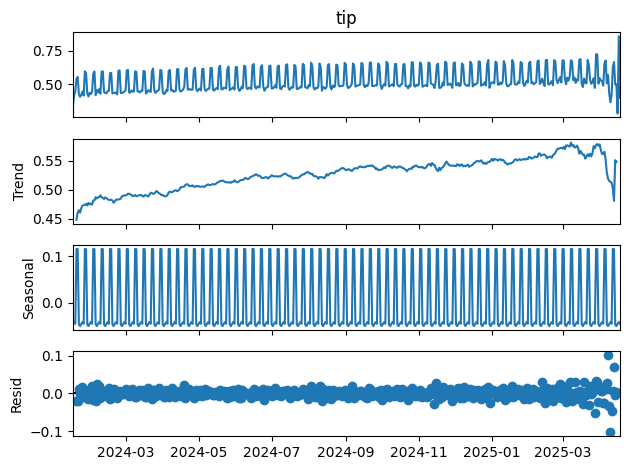

In [ ]:
plot_additive = seasonal_decompose(df.tip, model="additive", period=7)
plot_additive.plot()
plt.show()

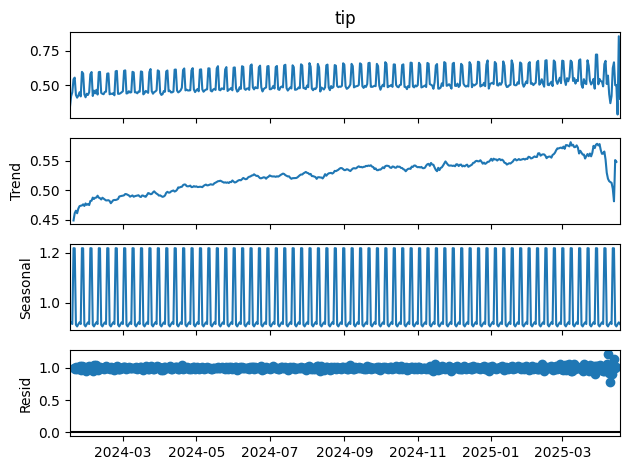

In [ ]:
plot_multiplicative = seasonal_decompose(df.tip, model="multiplicative", period=7)
plot_multiplicative.plot()
plt.show()

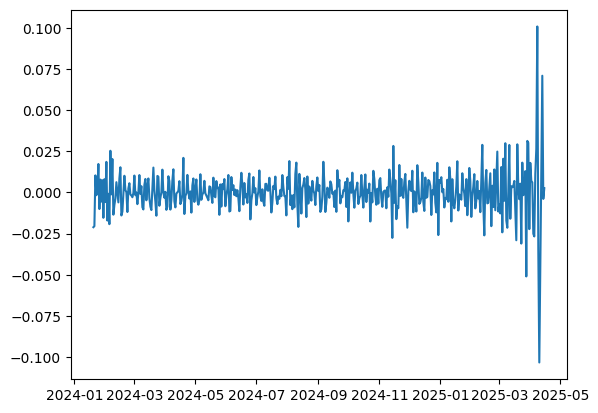

In [ ]:
cleaned = plot_additive.resid
plt.plot(cleaned)

In [5]:
class SinCosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period: int) -> None:
        self.period = period

    def fit(self, X: pd.DataFrame, y: Optional[Union[pd.Series, pd.DataFrame]] = None) -> SinCosTransformer:
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if isinstance(X, (pd.Series, np.ndarray)):
            X_transformed = pd.DataFrame(X)
        else:
            X_transformed = X.copy()

        for col in X_transformed.columns:
            X_transformed[f"{col}_sin"] = np.sin((2 * np.pi * X_transformed[col]) / self.period)
            X_transformed[f"{col}_cos"] = np.cos((2 * np.pi * X_transformed[col]) / self.period)

        return X_transformed.filter(regex="_sin|_cos")

In [6]:
def feature_preprocessing(df: pd.DataFrame, lags: int, min_date_global: pd.Timestamp = None) -> Tuple[pd.DataFrame, ColumnTransformer]:
    df_copy = df.copy()

    print("\n--- Begin Feature Preprocessing. ---")

    # Datumskonvertierung
    if not pd.api.types.is_datetime64_any_dtype(df_copy['order_date']):
        df_copy['order_date'] = pd.to_datetime(df_copy['order_date'])

    # Bestimmung des globalen Startdatums
    if min_date_global is None:
        min_date_global = df_copy['order_date'].min()

    user_clusters_df = generate_clusters(df_copy)
    df_copy = df_copy.merge(user_clusters_df)

    del user_clusters_df
    gc.collect()

    df_copy["cluster"] = df_copy.cluster.fillna(-1).astype(int).astype(str)

    print("\t- Generate Time-based Features.")

    # Generierung grundlegender zeitlicher Features
    df_copy['days_since_start'] = (df_copy['order_date'] - min_date_global).dt.days
    df_copy['weekday'] = df_copy['order_date'].dt.dayofweek
    df_copy["hour"] = df_copy.order_date.dt.hour

    # Sortieren der Daten ist essenziell für Shifted Features
    df_copy.sort_values(by=['user_id', 'order_date'], inplace=True)

    # Kennzeichnung der ursprünglichen Ziel-NaNs (sehr wichtig für Train/Predict-Split)
    df_copy["is_target_nan"] = df_copy.tip.isna()

    # 1. Erstellung der Basis-Spalte für das Shifting: 'tip_for_shifting'
    # Diese Spalte muss NaN-frei sein, um die Shift-Operationen konsistent zu halten.
    # Sie wird nur für die *Erstellung der Features* verwendet, nicht als Zielvariable.
    print("\t- Preparing Data for Shifting.")
    if df_copy.tip.isna().any():
        df_copy["tip_for_shifting"] = df_copy.groupby("user_id").tip.ffill()
        df_copy["tip_for_shifting"] = df_copy.groupby("user_id").tip_for_shifting.bfill()
    else:
        df_copy["tip_for_shifting"] = df_copy["tip"]

    # 2. Erstellen der Shifted Features und ihrer NaN-Indikatoren
    shifted_tip_features = []       # Namen der 'tip_t-X' Spalten (mit gefüllten Werten)
    shifted_nan_indicators = []     # Namen der 'tip_t-X_is_nan' Spalten (0/1 Indikatoren)

    print("\t- Generating shifted Features.")
    for lag in range(1, lags + 1):
        lag_feature_name = f"tip_t-{lag}"
        nan_indicator_name = f"tip_t-{lag}_is_nan"

        df_copy[lag_feature_name] = df_copy.groupby("user_id").tip_for_shifting.shift(lag)
        df_copy[nan_indicator_name] = df_copy[lag_feature_name].isna().astype(int)

        # NaNs im Shift Feature füllen. Hier verwenden wir -1, um die "Nicht-Existenz" zu signalisieren.
        df_copy[lag_feature_name] = df_copy[lag_feature_name].fillna(-1)

        shifted_tip_features.append(lag_feature_name)
        shifted_nan_indicators.append(nan_indicator_name)

    # Definieren der Feature-Listen für ColumnTransformer
    categorical_features = ["user_id", "cluster"]
    numerical_features_to_scale = shifted_tip_features + ["days_since_start"]  # Diese werden skaliert
    numerical_features_passthrough = shifted_nan_indicators  # Diese werden 0/1 übergeben und NICHT skaliert

    print("\n\t- Initializing Preprocessor.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num_shifted_tips', StandardScaler(), numerical_features_to_scale),
            ("weekly", SinCosTransformer(period=7), ["weekday"]),
            ("hourly", SinCosTransformer(period=24), ["hour"]),
            ('nan_indicators', 'passthrough', numerical_features_passthrough)  # Die _is_nan Features
        ],
        remainder='drop'  # Stellt sicher, dass nur die explizit gelisteten Features an das Modell gehen.
    )

    print("\t- Feature Preprocessing finished successfully!")

    return df_copy, preprocessor

In [ ]:
def _generate_temporal_features(df: pd.DataFrame, min_date_global: pd.Timestamp):
    # Generierung grundlegender zeitlicher Features
    df['days_since_start'] = (df['order_date'] - min_date_global).dt.days
    df['weekday'] = df['order_date'].dt.dayofweek
    df["hour"] = df.order_date.dt.hour

    # Sortieren der Daten ist essenziell für Shifted Features
    df.sort_values(by=['user_id', 'order_date'], inplace=True)

In [ ]:
def _shift_features(df: pd.DataFrame, lags: int):
    # 1. Erstellung der Basis-Spalte für das Shifting: 'tip_for_shifting'
    # Diese Spalte muss NaN-frei sein, um die Shift-Operationen konsistent zu halten.
    # Sie wird nur für die *Erstellung der Features* verwendet, nicht als Zielvariable.
    print("\t- Preparing Data for Shifting.")
    if df.tip.isna().any():
        df["tip_for_shifting"] = df.groupby("user_id").tip.ffill()
        df["tip_for_shifting"] = df.groupby("user_id").tip_for_shifting.bfill()
    else:
        df["tip_for_shifting"] = df["tip"]

    # 2. Erstellen der Shifted Features und ihrer NaN-Indikatoren
    shifted_tip_features = []  # Namen der 'tip_t-X' Spalten (mit gefüllten Werten)
    shifted_nan_indicators = []  # Namen der 'tip_t-X_is_nan' Spalten (0/1 Indikatoren)

    print("\t- Generating shifted Features.")
    for lag in range(1, lags + 1):
        lag_feature_name = f"tip_t-{lag}"
        nan_indicator_name = f"tip_t-{lag}_is_nan"

        # Shift Feature erstellen. Dies kann NaNs enthalten (für die ersten Beobachtungen pro User).
        df[lag_feature_name] = df.groupby("user_id").tip_for_shifting.shift(lag)

        # Indikator für NaNs im Shift Feature erstellen (Dies ist entscheidend! VOR der Füllung).
        df[nan_indicator_name] = df[lag_feature_name].isna().astype(int)

        # NaNs im Shift Feature füllen. Hier verwenden wir -1, um die "Nicht-Existenz" zu signalisieren.
        df[lag_feature_name] = df[lag_feature_name].fillna(-1)

        shifted_tip_features.append(lag_feature_name)
        shifted_nan_indicators.append(nan_indicator_name)

In [7]:
def generate_clusters(df: pd.DataFrame):
    print("\n\t--- Begin Cluster Generation ---")
    print("\t\t- Preparing Data.")
    user_dept_df = df.pivot_table(index="user_id", columns="tip", aggfunc="size", fill_value=0)

    scaler = StandardScaler()

    print("\t\t- Scaling Features.")
    scaled_features = scaler.fit_transform(user_dept_df)

    del scaler
    gc.collect()

    n_clusters = 4

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    print("\t\t- Starting KMeans Algorithm for Cluster Identification.")
    clusters = kmeans.fit_predict(scaled_features)

    del scaled_features, kmeans
    gc.collect()

    print("\t\t- Extracting relevant Data.")
    user_clusters_df = pd.DataFrame({"user_id": user_dept_df.index, "cluster": clusters})
    print("\t\t- Cluster Generation finished successfully!")

    del user_dept_df
    gc.collect()

    return user_clusters_df

In [ ]:
def feature_preprocessing(df: pd.DataFrame, tip_data: pd.DataFrame, lags: int, min_date_global: pd.Timestamp = None) -> Tuple[pd.DataFrame, ColumnTransformer]:
    df_copy = df.copy()
    tip_data = tip_data.copy()

    print("\n--- Begin Feature Preprocessing. ---")

    df_copy = df_copy.merge(tip_data)
    df_copy["tip"] = df_copy.tip.astype(int)

    # Datumskonvertierung
    if not pd.api.types.is_datetime64_any_dtype(df_copy['order_date']):
        df_copy['order_date'] = pd.to_datetime(df_copy['order_date'])

    # Bestimmung des globalen Startdatums
    if min_date_global is None:
        min_date_global = df_copy['order_date'].min()

    print("\t- Generate Time-based Features.")

    _generate_temporal_features(df_copy, min_date_global)

    # Kennzeichnung der ursprünglichen Ziel-NaNs (sehr wichtig für Train/Predict-Split)
    df_copy["is_target_nan"] = df_copy.tip.isna()

    _shift_features(df_copy, lags)

    user_clusters_df = generate_clusters(df_copy)
    df_copy = df_copy.merge(user_clusters_df)

    del user_clusters_df
    gc.collect()

    df_copy["cluster"] = df_copy.cluster.fillna(-1).astype(int).astype(str)

    # Definieren der Feature-Listen für ColumnTransformer
    categorical_features = ["user_id", "cluster"]
    numerical_features_to_scale = shifted_tip_features + ["days_since_start"]  # Diese werden skaliert
    numerical_features_passthrough = shifted_nan_indicators  # Diese werden 0/1 übergeben und NICHT skaliert

    print("\n\t- Initializing Preprocessor.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num_shifted_tips', StandardScaler(), numerical_features_to_scale),
            ("weekly", SinCosTransformer(period=7), ["weekday"]),
            ("hourly", SinCosTransformer(period=24), ["hour"]),
            ('nan_indicators', 'passthrough', numerical_features_passthrough)  # Die _is_nan Features
        ],
        remainder='drop'  # Stellt sicher, dass nur die explizit gelisteten Features an das Modell gehen.
    )

    print("\t- Feature Preprocessing finished successfully!")

    return df_copy, preprocessor

In [12]:
from sklearn.metrics import log_loss


def train_ar_extended_new(df_input: pd.DataFrame, lags: int) -> Tuple[LogisticRegressionCV, ColumnTransformer, pd.Timestamp, float]:
    df_input = df_input.copy()

    min_date_global_training = df_input.order_date.min()

    df_with_all_features, _ = feature_preprocessing(df_input, lags, min_date_global=min_date_global_training)

    del _
    gc.collect()

    all_relevant_cols = [f"tip_t-{lag}" for lag in range(1, lags + 1)]\
                        + [f"tip_t-{lag}_is_nan" for lag in range(1, lags + 1)]\
                        + ["days_since_start", "order_date", "weekday", "hour", "user_id", "tip", "cluster"]

    df_cleaned_for_training = df_with_all_features[~df_with_all_features['is_target_nan']].copy()

    min_date_for_pred = df_input.order_date.min()

    del df_with_all_features, df_input
    gc.collect()

    df_cleaned_for_training.set_index("order_date", inplace=True)

    y = df_cleaned_for_training.pop("tip")

    categorical_features = ["user_id", "cluster"]
    numerical_features_to_scale = [f"tip_t-{lag}" for lag in range(1, lags + 1)] + ["days_since_start"]
    numerical_features_passthrough = [f"tip_t-{lag}_is_nan" for lag in range(1, lags + 1)]
    time_based_features = ["weekday", "hour"]

    X_processed = df_cleaned_for_training[categorical_features + numerical_features_to_scale + numerical_features_passthrough + time_based_features]

    del df_cleaned_for_training
    gc.collect()

    fold_acc_scores = []
    tscv = TimeSeriesSplit(n_splits=5)
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_processed)):
        print(f"\n--- Aktueller Fold: {i + 1} ---")
        X_train, X_test = X_processed.iloc[train_idx], X_processed.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        del train_idx, test_idx
        gc.collect()

        print("\t- Preprocessing")
        current_preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                ("num", StandardScaler(), numerical_features_to_scale),
                ("weekly", SinCosTransformer(period=7), ["weekday"]),
                ("hourly", SinCosTransformer(period=24), ["hour"]),
                ("nan_indicators", "passthrough", numerical_features_passthrough)
            ], remainder="drop"
        )
        current_preprocessor.fit(X_train)

        X_train_transformed = current_preprocessor.transform(X_train)
        X_test_transformed = current_preprocessor.transform(X_test)

        del current_preprocessor, X_train, X_test
        gc.collect()

        print("\t- Training")
        current_model = LogisticRegressionCV(cv=5, scoring="neg_log_loss", n_jobs=-1, max_iter=1000)  # CHANGED SCORING
        current_model.fit(X_train_transformed, y_train)

        del X_train_transformed, y_train
        gc.collect()

        print("\t- Testing")
        y_pred = current_model.predict_proba(X_test_transformed)  # CHANGED PREDICT
        # accuracy = accuracy_score(y_test, y_pred)
        accuracy = log_loss(y_test, y_pred)  # CHANGED FROM ACCURACY

        del X_test_transformed, y_pred, current_model, y_test
        gc.collect()

        fold_acc_scores.append(accuracy)

    del tscv
    gc.collect()

    acc_mean = np.mean(fold_acc_scores)

    print("--- Finally ---")
    print("\t- Preprocessing")
    final_preprocessor_for_pred = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", StandardScaler(), numerical_features_to_scale),
            ("weekly", SinCosTransformer(period=7), ["weekday"]),
            ("hourly", SinCosTransformer(period=24), ["hour"]),
            ("nan_indicators", "passthrough", numerical_features_passthrough)
        ], remainder="drop"
    )
    final_preprocessor_for_pred.fit(X_processed)

    X_processed_transformed = final_preprocessor_for_pred.transform(X_processed)

    del X_processed
    gc.collect()

    print("\t- Training")
    final_model_for_pred = LogisticRegressionCV(cv=5, scoring="neg_log_loss", n_jobs=-1, max_iter=1000)  # CHANGED SCORING
    final_model_for_pred.fit(X_processed_transformed, y)
    print("\t- Model training finished successfully!")

    del X_processed_transformed
    gc.collect()

    return final_model_for_pred, final_preprocessor_for_pred, min_date_for_pred, acc_mean

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.compose import ColumnTransformer
from typing import Tuple, Optional # Added Optional for min_date_global
# Assuming feature_preprocessing is defined elsewhere and imported.
# Assuming pd.Timestamp is imported or used as pd.Timestamp.

def make_predictions(
    data_frame: pd.DataFrame,
    trained_model: LogisticRegressionCV,
    trained_preprocessor: ColumnTransformer,
    lags: int,
    min_date_from_training: pd.Timestamp
) -> pd.DataFrame:
    """
    Generates tip probability predictions for new, unseen orders using a
    pre-trained model and preprocessor.

    This function applies the same feature engineering and preprocessing steps
    used during training to the new data, then uses the trained model to make predictions.
    It specifically targets orders where the tip value is missing (NaN),
    assuming these are the instances requiring prediction.

    Args:
        data_frame (pd.DataFrame): Input DataFrame containing order data for which
                                   predictions are to be made. This DataFrame should
                                   include 'order_id', 'user_id', 'order_date',
                                   and potentially other features used during training.
                                   It should also contain 'tip' column with NaNs for
                                   prediction targets.
        trained_model (LogisticRegressionCV): The machine learning model
                                              (e.g., LogisticRegressionCV) that has
                                              already been fitted on training data.
        trained_preprocessor (ColumnTransformer): The fitted ColumnTransformer
                                                  used during training to preprocess
                                                  the features. It must be consistent
                                                  with the features expected by the model.
        lags (int): The number of historical orders (lags) used as features
                    in the autoregressive components of the model. Must match
                    the 'lags' used during model training.
        min_date_from_training (pd.Timestamp): The global minimum order date
                                                used during feature generation in the
                                                training phase. This ensures 'days_since_start'
                                                is calculated consistently.

    Returns:
        pd.DataFrame: A DataFrame containing 'order_id' and the binary
                      'tip' prediction (True/False or 1/0) for the orders
                      that initially had missing tip values.

    Raises:
        ValueError: If any NaN values are found in the final predictions,
                    indicating a potential issue in preprocessing or model output.
    """
    df_for_prediction = data_frame.copy()

    # Apply the same feature engineering and preprocessing pipeline used during training.
    # The 'min_date_global' argument ensures consistency in time-based feature calculation.
    # The second return value (_) from feature_preprocessing is not needed here.
    data_frame_features, _ = feature_preprocessing(
        df_for_prediction,
        lags,
        min_date_global=min_date_from_training
    )

    # Define the exact feature categories as used in the trained preprocessor.
    # Ensure this matches the definition in feature_preprocessing.
    categorical_features = ["user_id"]
    numerical_features_to_scale = [f"tip_t-{lag}" for lag in range(1, lags + 1)] + ["days_since_start"]
    numerical_features_passthrough = [f"tip_t-{lag}_is_nan" for lag in range(1, lags + 1)]
    temporal_features = ["weekday", "hour"]

    # Filter the DataFrame to include only rows that were originally marked
    # as having missing 'tip' values (i.e., the prediction targets).
    data_frame_features = data_frame_features[data_frame_features.is_target_nan == True]

    data_frame_features.drop(columns=["tip"], inplace=True)

    # Select the specific features for prediction and drop any rows where these
    # final features might still contain NaNs (e.g., if a user has no historical data for lagging).
    features_for_pred = data_frame_features[
        categorical_features +
        numerical_features_to_scale +
        numerical_features_passthrough +
        temporal_features
    ].dropna()  # .dropna() handles cases where even after ffill/bfill, some initial rows for a user might still lack full lag data

    # Transform the selected features using the *fitted* preprocessor from training.
    # This step applies the same scaling and encoding learned from the training data.
    X_transformed = trained_preprocessor.transform(features_for_pred)

    # Generate predictions using the trained model.
    predictions = trained_model.predict(X_transformed)

    data_frame["prediction"] = np.nan

    # Map the generated predictions back to their original 'order_id' rows
    # using the index of 'features_for_pred'.
    data_frame.loc[features_for_pred.index, "prediction"] = predictions

    # Create the final output DataFrame, containing only 'order_id' and the 'prediction'.
    # Filter for rows that originally had missing tip values (the prediction targets).
    df_final = data_frame[data_frame.tip.isna()][["order_id", "prediction"]].reset_index(drop=True)

    if df_final.prediction.isna().values.any():
        raise ValueError("Predictions contain NaN values! Check preprocessing or input data completeness.")

    # Convert predictions to boolean type (True/False) for clarity, assuming 0/1 output.
    df_final["prediction"] = df_final.prediction.astype(bool)

    # Rename the 'prediction' column to 'tip' to match the expected output format.
    df_final.rename(columns={"prediction": "tip"}, inplace=True)

    return df_final

In [13]:
final_model, final_preprocessor, min_date, f1_mean =\
    train_ar_extended_new(orders_tips, lags=4)


--- Begin Feature Preprocessing. ---

	--- Begin Cluster Generation ---
		- Preparing Data.
		- Scaling Features.
		- Starting KMeans Algorithm for Cluster Identification.
		- Extracting relevant Data.
		- Cluster Generation finished successfully!
	- Generate Time-based Features.
	- Preparing Data for Shifting.
	- Generating shifted Features.

	- Initializing Preprocessor.
	- Feature Preprocessing finished successfully!

--- Aktueller Fold: 1 ---
	- Preprocessing
	- Training
	- Testing

--- Aktueller Fold: 2 ---
	- Preprocessing
	- Training
	- Testing

--- Aktueller Fold: 3 ---
	- Preprocessing
	- Training
	- Testing

--- Aktueller Fold: 4 ---
	- Preprocessing
	- Training
	- Testing

--- Aktueller Fold: 5 ---
	- Preprocessing
	- Training
	- Testing
--- Finally ---
	- Preprocessing
	- Training
	- Model training finished successfully!


In [14]:
f1_mean

np.float64(0.5113938045660475)

In [ ]:
tip_temp = pd.read_csv("tip_testdaten_template_V2.csv", usecols=["order_id", "tip"])

In [ ]:
tip_temp_test = pd.concat([tips, tip_temp])
tip_temp_test = tip_temp_test.merge(orders)

In [ ]:
tip_temp_test = tip_temp_test[tip_temp_test.user_id.isin(tip_temp_test[tip_temp_test.tip.isna()].user_id.unique())].sort_values(["user_id", "order_date"])

In [ ]:
pred_df = make_predictions(tip_temp_test, final_model, final_preprocessor, 3, min_date)


--- Begin Feature Preprocessing. ---

	--- Begin Cluster Generation ---
		- Preparing Data.
		- Scaling Features.
		- Starting KMeans Algorithm for Cluster Identification.
		- Extracting relevant Data.
		- Cluster Generation finished successfully!
	- Generate Time-based Features.
	- Preparing Data for Shifting.
	- Generating shifted Features.

	- Initializing Preprocessor.
	- Feature Preprocessing finished successfully!


KeyError: '[4, 17, 171, 356, 366, 379, 387, 408, 556, 757, 764, 1040, 1045, 1166, 1170, 1174, 1181, 1658, 1663, 1672, 1744, 1750, 1763, 1769, 1784, 1793, 1809, 1813, 2034, 2039, 2053, 2065, 2133, 2188, 2212, 2467, 2608, 2622, 2633, 2740, 2752, 2756, 2903, 3063, 3090, 3226, 3261, 3321, 3331, 3361, 3365, 3436, 3447, 3547, 3552, 3577, 3599, 3621, 3746, 4027, 4199, 4221, 4362, 4372, 4376, 4435, 4439, 4447, 4543, 4552, 4572, 4584, 4590, 4769, 4959, 5050, 5069, 5121, 5188, 5238, 5246, 5257, 5269, 5380, 5399, 5504, 5510, 5766, 5777, 5945, 5951, 5964, 6069, 6073, 6080, 6088, 6378, 6399, 6404, 6428, 6451, 6466, 6492, 6500, 6514, 6547, 6582, 6658, 6687, 6799, 6812, 6816, 6820, 6827, 6899, 6903, 6912, 6916, 6935, 6942, 6946, 6961, 6974, 6981, 7073, 7410, 7416, 7532, 7555, 7637, 7651, 7717, 7721, 7751, 7907, 8103, 8108, 8112, 8122, 8126, 8571, 8578, 8613, 8618, 8740, 8744, 8757, 8768, 8774, 8789, 8925, 8936, 8959, 8964, 8974, 8979, 9009, 9013, 9026, 9181, 9186, 9269, 9273, 9305, 9309, 9341, 9347, 9351, 9430, 9461, 9586, 9636, 9641, 9787, 9797, 9802, 9813, 9819, 9948, 9955, 9959, 9986, 10122, 10353, 10362, 10371, 10407, 10444, 10454, 10485, 10546, 10681, 10712, 10716, 10732, 10918, 10944, 10987, 10993, 11035, 11047, 11207, 11242, 11251, 11256, 11262, 11276, 11348, 11353, 11431, 11435, 11762, 11770, 11858, 11865, 12011, 12099, 12104, 12115, 12122, 12127, 12133, 12195, 12205, 12213, 12217, 12249, 12254, 12262, 12455, 12463, 12537, 12551, 12593, 12600, 12605, 12657, 12664, 12668, 12723, 12774, 12848, 12852, 12900, 12928, 12947, 12954, 12959, 12981, 13020, 13046, 13271, 13307, 13333, 13382, 13387, 13457, 13686, 13829, 14042, 14054, 14097, 14117, 14124, 14142, 14147, 14474, 14526, 14532, 14538, 14545, 14549, 14553, 14657, 14663, 14671, 14682, 14758, 14762, 14834, 14849, 14862, 14933, 14937, 14946, 14965, 14973, 15215, 15295, 15360, 15364, 15368, 15555, 15619, 15912, 15950, 15954, 15959, 16000, 16467, 16473, 16477, 16484, 16552, 16647, 16656, 16926, 16940, 16944, 16951, 17052, 17240, 17289, 17335, 17341, 17551, 17560, 17779, 17801, 17825, 17844, 17895, 17982, 18084, 18259, 18266, 18359, 18378, 18382, 18387, 18458, 18686, 18690, 18772, 18842, 18878, 18977, 19183, 19204, 19425, 19658, 19743, 19749, 19767, 19779, 19834, 19840, 19886, 20157, 20170, 20192, 20200, 20204, 20213, 20255, 20262, 20351, 20411, 21075, 21101, 21229, 21674, 21678, 21692, 21696, 21780, 21812, 22039, 22061, 22078, 22123, 22161, 22352, 22367, 22396, 22496, 22515, 22520, 22524, 22544, 22556, 22563, 22645, 22660, 22665, 22672, 22676, 22681, 22708, 22772, 22968, 23063, 23071, 23130, 23198, 23211, 23240, 23441, 23498, 23953, 23959, 23977, 24117, 24129, 24238, 24251, 24259, 24272, 24358, 24510, 24515, 24962, 24966, 24982, 25007, 25105, 25112, 25303, 25317, 25335, 25696, 25751, 25762, 25812, 25817, 25821, 25832, 26241, 26345, 26354, 26360, 26370, 26387, 26392, 26434, 26495, 26501, 26509, 26515, 26519, 26524, 27034, 27041, 27085, 27094, 27145, 27183, 27188, 27284, 27293, 27313, 27324, 27328, 27333, 27337, 27346, 27372, 27426, 27434, 27441, 27453, 27463, 27470, 27481, 27540, 27544, 27548, 27585, 27593, 27599, 27646, 27863, 28090, 28174, 28224, 28245, 28252, 28259, 28271, 28297, 28342, 28806, 28988, 28992, 28999, 29013, 29078, 29083, 29294, 29299, 29314, 29613, 29621, 29625, 29649, 29654, 29664, 29770, 29854, 29858, 29866, 29872, 29878, 29977, 29983, 30038, 30061, 30161, 30221, 30225, 30260, 30305, 30324, 30330, 30520, 30545, 30705, 31263, 31269, 31281, 31286, 31291, 31978, 32019, 32029, 32034, 32038, 32091, 32124, 32128, 32142, 32146, 32150, 32154, 32182, 32199, 32233, 32239, 32246, 32251, 32674, 32695, 32720, 32724, 32757, 33132, 33190, 33196, 33233, 33252, 33293, 33348, 33388, 33404, 33603, 33894, 34329, 34385, 34389, 34398, 34446, 34467, 34484, 34550, 34713, 34750, 34754, 34765, 34791, 34832, 34872, 34972, 35035, 35040, 35045, 35050, 35098, 35103, 35120, 35152, 35307, 35312, 35452, 35456, 35465, 35470, 35518, 35529, 35537, 35563, 35567, 35572, 35584, 35589, 35609, 35614, 35643, 35654, 35658, 35966, 36146, 36186, 36204, 36216, 36220, 36224, 36234, 36239, 36479, 36483, 36563, 36714, 36736, 36758, 36858, 36873, 37118, 37122, 37147, 37155, 37231, 37246, 37317, 37377, 37383, 37397, 37443, 37447, 37656, 37662, 37671, 37785, 37950, 37961, 37967, 37971, 37978, 37985, 38012, 38160, 38212, 38407, 38417, 38421, 38426, 38473, 38479, 38551, 38649, 39131, 39207, 39260, 39275, 39346, 39502, 39507, 39603, 39748, 39752, 39756, 39790, 39862, 39962, 39976, 40232, 40470, 40589, 40673, 40770, 40870, 40874, 40934, 41020, 41024, 41043, 41273, 41280, 41292, 41314, 41533, 41654, 41659, 41729, 41790, 41801, 41812, 41822, 42159, 42171, 42179, 42190, 42206, 42302, 42322, 42349, 42363, 42376, 42383, 42401, 42436, 42443, 42517, 42543, 42570, 42575, 42595, 42603, 42684, 42719, 42723, 42794, 42883, 42896, 42912, 42998, 43002, 43044, 43048, 43054, 43105, 43111, 43430, 43794, 43800, 43806, 43810, 43991, 44294, 44307, 45340, 45345, 45477, 45596, 45603, 45609, 45614, 45620, 45927, 45956, 45960, 45975, 46048, 46052, 46085, 46093, 46103, 46206, 46237, 46544, 46552, 46802, 46819, 46823, 46956, 46961, 46964, 46971, 47145, 47303, 47474, 47503, 47740, 47839, 47844, 47848, 47866, 47871, 47880, 48095, 48107, 48335, 48339, 48346, 48363, 48417, 48421, 48445, 48454, 48919, 48964, 48983, 48989, 49136, 49186, 49192, 49196, 49255, 49262, 49271, 49526, 49669, 49674, 49678, 49708, 49748, 49994, 50165, 50222, 50227, 50235, 50399, 50523, 50528, 50533, 50539, 50548, 50553, 50559, 50564, 50568, 50572, 50589, 50687, 50695, 50699, 50737, 51318, 51342, 51347, 51357, 51417, 51590, 51721, 51736, 51785, 51798, 51855, 51859, 51921, 51957, 51994, 52092, 52096, 52178, 52182, 52250, 52257, 52268, 52407, 52534, 52553, 52660, 52672, 52682, 52946, 53149, 53177, 53334, 53340, 53544, 53571, 53578, 53582, 53612, 53618, 53624, 53730, 53745, 53838, 54022, 54030, 54050, 54231, 54237, 54248, 54297, 54302, 54307, 54341, 54349, 54583, 54603, 54635, 54729, 54895, 54963, 54968, 55088, 55202, 55214, 55329, 55508, 55721, 55734, 55753, 55774, 56110, 56115, 56120, 56185, 56191, 56201, 56282, 56291, 56297, 56306, 56821, 56845, 56900, 57025, 57081, 57092, 57178, 57191, 57201, 57210, 57372, 57383, 57437, 57475, 57486, 57491, 57556, 57583, 57588, 57782, 57794, 57941, 58050, 58108, 58112, 58199, 58204, 58208, 58227, 58232, 58342, 58346, 58748, 58834, 58987, 59159, 59165, 59175, 59182, 59337, 59341, 59611, 59696, 59791, 59878, 59891, 59898, 59903, 59961, 60177, 60181, 60379, 60417, 60425, 60436, 60452, 60937, 60941, 60962, 61106, 61123, 61208, 61313, 61611, 61700, 61710, 61750, 61754, 61759, 61830, 61882, 61889, 62072, 62078, 62166, 62177, 62277, 62368, 62384, 62507, 62544, 62549, 62554, 62558, 62682, 62688, 62695, 62701, 63125, 63306, 63310, 63316, 63356, 63590, 63610, 63626, 63637, 63644, 63655, 63660, 64184, 64326, 64434, 64449, 64477, 64520, 64576, 64589, 64593, 64601, 64678, 64682, 64686, 64862, 64873, 64879, 64901, 64946, 64990, 65035, 65053, 65057, 65065, 65080, 65100, 65105, 65120, 65278, 65586, 65594, 65835, 66105, 66272, 66277, 66296, 66302, 66308, 66313, 66325, 66348, 66354, 66383, 66394, 66433, 66525, 66557, 66581, 66654, 66663, 66668, 66679, 66702, 66708, 66736, 66740, 66887, 66912, 66917, 66923, 67131, 67306, 67316, 67337, 67363, 67369, 67660, 67720, 67724, 67751, 67758, 67804, 68069, 68081, 68155, 68159, 68167, 68177, 68273, 68282, 68339, 68634, 68857, 68866, 69142, 69197, 69382, 69616, 69620, 69624, 69888, 69891, 69896, 70073, 70078, 70140, 70150, 70190, 70203, 70219, 70372, 70742, 70748, 70914, 70921, 70924, 70931, 71078, 71082, 71087, 71101, 71190, 71223, 71243, 71449, 71462, 71474, 71486, 71674, 71698, 71705, 71795, 71802, 71945, 71982, 72005, 72013, 72017, 72046, 72314, 72592, 72665, 72672, 72733, 72737, 72771, 72844, 72861, 72885, 72921, 73109, 73136, 73142, 73152, 73157, 73493, 73570, 73585, 73679, 73739, 73747, 74151, 74170, 74175, 74366, 74374, 74544, 74750, 74756, 74875, 74962, 74980, 75013, 75290, 75419, 75434, 75442, 75446, 75465, 75757, 75770, 75870, 75898, 75911, 75931, 75939, 75948, 75953, 76053, 76101, 76413, 76417, 76435, 76587, 76742, 76867, 76873, 76877, 76881, 76897, 76925, 77069, 77170, 77211, 77215, 77219, 77223, 77232, 77339, 77349, 77400, 77415, 77439, 77472, 77479, 77483, 77629, 77683, 77895, 77912, 77919, 78236, 78413, 78419, 78754, 78823, 78861, 78906, 79048, 79052, 79065, 79072, 79095, 79131, 79137, 79146, 79432, 79437, 79444, 79450, 79583, 79605, 79623, 79627, 80013, 80030, 80145, 80263, 80270, 80318, 80516, 80522, 80527, 80646, 80652, 80656, 80663, 80669, 80769, 80903, 80922, 81023, 81029, 81047, 81080, 81241, 81245, 81316, 81334, 81650, 81832, 81849, 81857, 81864, 81949, 81995, 82001, 82317, 82324, 82351, 82362, 82367, 82420, 82521, 82525, 82577, 82702, 82971, 83055, 83074, 83327, 83333, 83343, 83350, 83502, 83687, 83694, 83699, 83704, 83709, 83806, 83812, 83822, 83983, 84037, 84048, 84052, 84076, 84087, 84095, 84103, 84135, 84168, 84177, 84181, 84219, 84223, 84229, 84311, 84328, 84522, 84678, 84701, 84730, 84833, 84845, 84851, 84856, 84993, 85041, 85125, 85130, 85135, 85145, 85151, 85306, 85468, 85512, 85725, 85750, 85789, 86071, 86129, 86134, 86183, 86219, 86229, 86234, 86261, 86268, 86302, 86363, 86396, 86552, 86569, 86584, 86627, 86635, 86658, 86792, 86796, 86800, 86807, 86976, 87072, 87080, 87101, 87223, 87254, 87268, 87493, 87508, 87520, 87524, 87578, 87720, 87726, 87738, 88062, 88147, 88160, 88183, 88194, 88198, 88204, 88257, 88274, 88331, 88686, 88741, 88822, 89114, 89125, 89137, 89517, 89610, 89659, 89674, 89683, 89709, 89785, 89790, 89821, 89830, 89834, 89934, 89970, 89974, 90039, 90043, 90048, 90054, 90060, 90319, 90367, 90375, 90382, 90388, 90439, 90447, 90463, 90682, 90766, 90964, 91111, 91133, 91140, 91144, 91185, 91189, 91194, 91322, 91368, 91373, 91537, 91542, 91574, 91916, 91930, 91963, 91969, 91974, 92025, 92035, 92053, 92076, 92085, 92096, 92109, 92116, 92300, 92309, 92317, 92357, 92587, 92591, 92642, 92667, 92685, 92691, 92711, 92759, 92883, 92906, 92911, 92957, 93042, 93048, 93062, 93078, 93145, 93149, 93592, 93607, 93612, 93621, 93626, 93762, 93771, 93785, 93836, 94036, 94136, 94140, 94413, 94435, 94546, 94626, 94717, 94728, 94963, 94970, 94980, 94995, 95000, 95086, 95094, 95098, 95262, 95501, 95726, 95854, 95911, 95941, 95948, 95998, 96027, 96151, 96155, 96160, 96176, 96283, 96293, 96483, 96685, 96781, 97124, 97131, 97166, 97253, 97358, 97788, 97812, 97828, 98325, 98374, 98701, 98716, 98980, 98984, 98988, 99164, 99221, 99225, 99229, 99268, 99277, 99282, 99288, 99484, 99534, 99539, 99557, 99572, 99591, 99601, 99607, 99616, 99683, 99687, 99986, 100056, 100124, 100167, 100200, 100204, 100318, 100328, 100332, 100631, 100657, 100999, 101079, 101086, 101110, 101207, 101256, 101273, 101281, 101298, 101309, 101313, 101328, 101337, 101344, 101646, 101734, 102219, 102487, 102503, 102556, 102601, 102608, 102614, 102681, 102702, 102864, 102972, 102976, 103109, 103209, 103222, 103296, 103335, 103355, 103467, 103582, 103613, 103622, 103923, 103984, 103999, 104003, 104264, 104274, 104296, 104415, 104419, 104423, 104469, 104476, 104517, 104559, 104563, 104627, 104719, 104724, 104730, 104799, 105006, 105024, 105066, 105135, 105163, 105170, 105175, 105186, 105289, 105293, 105411, 105622, 105627, 105667, 105692, 105741, 105748, 105789, 105824, 105851, 105885, 105921, 105931, 106499, 106507, 106816, 106822, 106912, 107062, 107139, 107172, 107177, 107308, 107314, 107318, 107385, 107612, 107634, 107711, 107762, 107768, 107781, 107785, 107792, 107799, 107864, 108030, 108061, 108178, 108267, 108314, 108318, 108373, 108441, 108472, 108909, 108946, 108951, 108955, 108959, 108974, 108984, 108993, 109235, 109239, 109249, 109254, 109284, 109304, 109314, 109503, 109507, 109511, 109642, 109743, 109750, 109754, 109810, 109814, 109818, 109840, 109932, 109940, 109951, 110396, 110557, 110617, 110621, 110629, 110635, 110758, 110805, 110823, 110960, 111052, 111059, 111076, 111081, 111121, 111130, 111246, 111251, 111275, 111425, 111433, 111711, 111753, 112086, 112110, 112144, 112175, 112192, 112197, 112201, 112402, 112406, 112414, 112419, 112434, 112465, 112525, 112657, 112662, 112738, 112745, 112749, 112777, 112836, 112842, 112862, 112869, 112874, 112878, 112936, 112940, 113132, 113230, 113234, 113240, 113249, 113253, 113259, 113343, 113414, 113514, 113667, 114615, 114736, 114746, 114753, 114757, 114763, 114772, 114781, 115028, 115039, 115171, 115209, 115215, 115219, 115245, 115369, 115376, 115380, 115719, 115739, 115745, 115749, 115977, 115992, 116164, 116283, 116288, 116305, 116310, 116473, 116482, 116486, 116520, 116561, 116626, 116633, 116638, 117009, 117018, 117207, 117211, 117492, 117576, 117763, 117776, 117782, 117788, 117876, 117909, 118173, 118186, 118192, 118257, 118263, 118352, 118665, 118669, 118690, 118775, 118779, 118871, 118908, 118975, 118984, 119047, 119079, 119261, 119265, 119269, 119379, 119425, 119601, 119657, 119663, 119844, 119851, 119862, 119872, 119887, 119909, 120060, 120069, 120077, 120084, 120228, 120233, 120300, 120304, 120439, 120541, 120578, 120585, 120592, 120761, 120804, 120877, 120951, 121022, 121076, 121127, 121137, 121143, 121147, 121604, 121837, 122362, 122369, 122387, 122396, 122552, 122557, 122562, 122694, 122793, 122798, 122847, 122867, 122878, 122883, 122901, 122908, 122914, 123132, 123263, 123269, 123275, 123279, 123284, 123292, 123297, 123307, 123334, 123709, 123714, 123917, 123921, 124115, 124133, 124262, 124306, 124388, 124667, 124723, 124730, 124743, 124752, 124760, 124765, 125119, 125214, 125476, 125649, 125740, 125747, 125776, 125780, 125836, 125840, 126540, 126559, 126570, 126575, 126583, 126665, 126681, 126685, 126812, 126816, 126820, 126840, 126858, 126871, 126971, 127060, 127066, 127134, 127144, 127155, 127159, 127169, 127176, 127834, 127914, 128044, 128051, 128124, 128142, 128173, 128177, 128184, 128371, 128401, 128412, 128429, 128703, 128718, 128725, 128729, 128733, 128873, 128988, 128992, 129127, 129150, 129165, 129307, 129315, 129406, 129487, 129492, 129965, 129977, 129981, 130011, 130024, 130035, 130041, 130051, 130077, 130101, 130106, 130177, 130181, 130458, 130483, 130539, 130554, 130753, 130824, 130832, 130837, 131075, 131085, 131103, 131128, 131132, 131156, 131234, 131344, 131356, 131367, 131638, 131867, 131874, 131886, 131936, 131972, 132034, 132053, 132117, 132123, 132127, 132132, 132173, 132178, 132351, 132384, 132395, 132408, 132537, 132764, 132789, 132829, 132836, 132854, 132865, 132878, 132885, 132893, 132899, 132911, 132947, 132963, 133269, 133386, 133480, 133503, 133510, 133516, 133563, 133873, 134066, 134074, 134078, 134090, 134184, 134264, 134269, 134274, 134374, 134379, 134390, 134397, 134465, 134469, 134482, 134525, 134540, 134545, 134583, 134609, 134613, 134690, 134883, 134903, 134951, 135003, 135024, 135044, 135203, 135207, 135407, 135422, 135430, 135438, 135636, 135883, 136045, 136049, 136099, 136106, 136111, 136282, 136289, 136376, 136659, 136664, 136669, 136677, 136685, 136691, 136695, 136703, 136737, 136744, 136978, 136990, 136997, 137004, 137011, 137025, 137035, 137039, 137044, 137049, 137053, 137078, 137083, 137090, 137126, 137136, 137182, 137189, 137195, 137204, 137221, 137225, 137475, 137485, 137489, 137512, 137529, 137553, 137677, 138149, 138154, 138180, 138370, 138561, 138567, 138590, 138696, 138840, 138999, 139167, 139520, 139526, 139536, 139540, 139665, 139901, 139910, 140290, 140299, 140532, 140760, 140885, 140920, 141084, 141103, 141116, 141142, 141206, 141222, 141241, 141245, 141259, 141267, 141283, 141504, 141571, 141725, 141736, 141742, 141788, 141802, 141996, 142002, 142006, 142078, 142092, 142102, 142113, 142126, 142132, 142292, 142298, 142307, 142311, 142316, 142452, 142599, 142633, 142645, 142783, 142798, 142820, 142828, 142872, 142877, 143244, 143251, 143257, 143261, 143361, 143366, 143380, 143563, 143709, 143756, 144001, 144316, 144335, 144355, 144360, 144370, 144384, 144687, 144691, 144695, 144701, 144709, 144715, 144872, 144878, 144894, 144917, 144946, 145223, 145227, 145247, 145366, 145376, 145424, 145428, 145440, 145505, 145528, 145657, 145665, 145669, 145682, 145804, 145904, 145913, 145929, 145956, 145962, 145968, 145974, 145979, 146176, 146182, 146186, 146303, 146310, 146399, 146411, 146417, 146433, 146454, 146459, 146463, 146470, 146482, 146486, 146592, 146738, 146750, 146757, 146767, 147024, 147048, 147052, 147058, 147248, 147300, 147309, 147432, 147443, 147477, 147481, 147490, 147497, 147501, 147512, 147575, 147610, 147620, 147628, 147635, 147639, 147710, 147827, 147836, 147904, 148107, 148115, 148120, 148125, 148176, 148183, 148211, 148249, 148278, 148318, 148324, 148443, 148464, 148941, 148945, 148949, 148954, 148974, 149073, 149263, 149545, 149551, 149560, 149564, 149584, 149908, 149980, 150026, 150088, 150097, 150143, 150151, 150478, 150556, 150571, 150604, 150654, 150660, 150672, 150764, 150783, 150807, 150912, 150995, 151107, 151525, 151530, 151534, 151538, 151733, 152059, 152225, 152229, 152258, 152266, 152396, 152400, 152409, 152414, 152473, 152479, 152485, 152743, 152865, 152992, 152998, 153211, 153330, 153352, 153504, 153509, 153667, 153702, 153707, 153711, 154234, 154328, 154338, 154360, 154494, 154534, 154539, 154805, 154875, 154880, 154885, 155107, 155253, 155266, 155271, 155397, 155402, 155451, 155459, 155897, 155937, 155951, 156038, 156043, 156143, 156151, 156577, 156647, 156656, 157041, 157049, 157301, 157577, 157598, 157603, 157720, 157815, 157828, 157951, 158004, 158180, 158196, 158200, 158207, 158354, 158358, 158416, 158438, 158447, 158711, 158837, 158851, 158931, 158938, 158957, 159152, 159246, 159262, 159429, 159433, 159541, 159641, 159649, 159780, 159796, 159800, 159807, 159846, 159869, 159904, 159915, 160107, 160113, 160118, 160124, 160475, 160526, 160576, 160617, 160621, 160625, 160652, 160685, 160973, 160993, 161004, 161010, 161110, 161286, 161294, 161306, 161351, 161485, 161491, 161500, 161504, 161512, 161536, 161543, 161660, 161680, 161796, 161893, 162082, 162093, 162116, 162362, 162373, 162380, 162409, 162468, 162475, 162492, 162813, 162835, 162839, 162844, 162848, 162874, 162889, 162955, 163137, 163144, 163174, 163221, 163236, 163242, 163260, 163264, 163477, 163559, 163564, 163569, 163578, 163619, 163623, 163632, 163646, 163723, 163728, 163738, 164212, 164225, 164229, 164235, 164343, 164400, 164540, 164544, 164756, 164769, 164823, 164908, 164957, 164996, 165014, 165027, 165133, 165137, 165582, 165588, 165599, 165630, 165656, 165687, 165694, 165820, 165932, 165944, 166070, 166104, 166109, 166113, 166118, 166161, 166234, 166238, 166245, 166250, 166258, 166264, 166268, 166343, 166350, 166358, 166364, 166373, 166473, 166601, 166606, 166613, 167056, 167061, 167068, 167230, 167234, 167392, 167622, 168055, 168071, 168184, 168234, 168257, 168300, 168326, 168334, 168355, 168492, 168496, 168782, 168892, 168901, 168921, 168941, 169006, 169109, 169115, 169648, 169665, 169701, 169720, 170093, 170097, 170186, 170209, 170215, 170229, 170260, 170266, 170434, 170443, 170498, 170681, 170686, 170690, 170694, 170707, 170712, 170812, 170831, 170840, 170966, 171029, 171113, 171309, 171325, 171331, 171337, 171391, 171450, 171466, 171643, 171673, 171686, 171699, 171706, 171760, 171778, 171795, 171800, 171805, 171962, 171968, 171974, 171984, 171989, 171993, 172005, 172010, 172015, 172052, 172204, 172208, 172255, 172427, 172664, 172994, 173194, 173222, 173231, 173241, 173301, 173313, 173436, 173446, 173461, 173796, 173815, 174287, 174292, 174325, 174332, 174465, 174721, 174779, 174832, 175487, 175574, 175890, 175906, 176116, 176143, 176266, 176279, 176293, 176300, 176304, 176312, 176599, 176603, 176609, 176618, 176623, 176627, 176631, 176640, 176647, 176651, 176728, 176773, 176777, 176781, 176789, 176797, 176801, 176875, 176984, 177008, 177017, 177056, 177069, 177313, 177317, 177402, 177406, 177410, 177618, 177698, 177705, 177709, 177825, 177943, 177948, 177952, 177970, 178092, 178501, 178551, 178681, 178764, 178792, 178834, 178847, 178892, 178926, 179193, 179200, 179212, 179219, 179253, 179362, 179366, 179371, 179424, 179513, 179517, 179535, 179539, 179828, 179941, 179945, 179953, 180025, 180038, 180043, 180052, 180261, 180383, 180389, 180640, 180646, 180653, 180660, 180714, 180721, 180735, 180807, 180823, 180829, 180892, 180896, 180913, 181391, 181504, 181508, 181523, 181599, 181603, 181610, 181651, 181672, 181956, 181969, 182022, 182028, 182363, 182372, 182376, 182389, 182394, 182399, 182532, 182565, 182626, 182642, 182756, 182770, 182975, 182981, 182988, 183023, 183027, 183031, 183039, 183044, 183184, 183218, 183379, 183387, 183554, 183647, 183672, 183687, 183790, 183839, 183865, 183883, 183890, 183900, 183912, 183917, 183984, 184022, 184061, 184109, 184291, 184298, 184305, 184326, 184407, 184745, 185199, 185213, 185380, 185387, 185398, 185403, 185414, 185439, 185444, 185526, 185530, 185555, 185565, 185752, 185767, 185771, 185807, 185815, 185887, 185920, 185990, 186006, 186027, 186043, 186051, 186086, 186094, 186155, 186159, 186165, 186170, 186176, 186229, 186379, 186402, 186443, 186851, 186855, 186862, 186879, 186919, 186923, 186931, 186936, 186940, 187127, 187131, 187152, 187162, 187200, 187208, 187212, 187222, 187605, 187609, 187689, 187697, 187722, 187917, 187921, 188010, 188169, 188189, 188515, 188520, 188524, 188610, 188632, 188650, 188665, 188737, 189175, 189241, 189251, 189260, 189289, 189294, 189605, 189610, 189693, 189923, 189931, 189972, 190215, 190245, 190311, 190337, 190341, 190526, 190532, 190539, 190773, 190806, 190810, 190819, 190868, 190873, 191093, 191131, 191396, 191535, 191543, 191552, 191556, 191614, 191693, 191837, 191844, 191858, 191871, 191904, 191908, 191966, 191978, 191987, 192127, 192153, 192158, 192166, 192266, 192282, 192286, 192350, 192410, 192415, 192419, 192426, 192605, 192610, 192614, 192618, 192701, 192717, 192725, 192751, 192845, 192850, 192883, 193102, 193106, 193116, 193151, 193167, 193179, 193225, 193428, 193437, 193441, 193468, 193530, 193546, 193688, 193865, 193877, 193898, 193917, 193953, 194315, 194327, 194335, 194435, 194496, 194529, 194540, 194562, 194566, 194571, 194580, 194746, 194761, 194774, 194778, 194796, 194804, 194809, 194819, 194834, 194838, 194842, 194861, 194865, 194870, 194880, 194925, 194995, 195175, 195211, 195292, 195338, 195342, 195350, 195356, 195362, 195632, 195878, 195910, 195920, 196155, 196171, 196178, 196183, 196442, 196465, 196633, 196651, 196663, 196670, 196675, 196681, 196685, 196689, 196695, 196734, 196813, 196920, 197020, 197087, 197123, 197167, 197186, 197222, 197237, 197254, 197270, 197274, 197307, 197337, 197689, 197693, 197803, 197814, 197824, 197828, 198029, 198192, 198196, 198201, 198205, 198753, 198999, 199017, 199146, 199168, 199191, 199216, 199226, 199230, 199234, 199242, 199477, 199562, 199604, 199964, 199968, 199973, 200103, 200148, 200211, 200218, 200266, 200275, 200355, 200396, 200403, 200408, 200413, 200623, 200643, 200648, 200748, 200755, 200769, 200981, 201024, 201044, 201048, 201138, 201352, 201493, 201501, 201637, 201644, 201736, 201894, 201904, 201908, 202146, 202153, 202157, 202179, 202183, 202187, 202202, 202581, 202596, 202770, 202786, 202790, 202795, 202799, 202852, 202884, 202888, 202903, 203003, 203172, 203232, 203319, 203326, 203332, 203362, 203510, 203558, 203734, 203738, 203778, 203788, 203801, 203805, 203812, 203987, 204028, 204038, 204043, 204469, 204545, 204626, 204633, 204637, 204664, 204679, 204779, 204784, 204845, 204849, 205075, 205084, 205091, 205100, 205104, 205232, 205285, 205289, 205677, 205897, 205911, 206024, 206098, 206221, 206248, 206252, 206258, 206268, 206281, 206291, 206295, 206554, 206882, 206941, 206946, 206995, 207015, 207019, 207190, 207196, 207697, 207712, 207768, 207772, 207777, 207782, 208018, 208025, 208041, 208051, 208082, 208092, 208255, 208260, 208269, 208382, 208567, 208602, 209142, 209312, 209316, 209324, 209388, 209661, 209765, 209771, 209775, 209834, 209847, 209861, 209986, 210226, 210230, 210239, 210247, 210352, 210361, 210366, 210370, 210375, 210383, 210387, 210532, 210717, 210886, 210909, 210920, 210926, 210959, 210964, 210968, 210975, 211022, 211026, 211462, 211466, 211526, 211531, 211686, 211691, 211696, 212017, 212031, 212113, 212144, 212301, 212333, 212338, 212346, 212352, 212361, 212365, 212417, 212424, 212428, 212433, 212479, 212546, 212557, 212597, 212608, 212621, 212626, 212641, 212699, 212858, 212867, 212887, 212977, 213348, 213354, 213383, 213389, 213396, 213401, 213405, 213410, 213419, 213469, 213489, 213502, 213507, 213511, 213534, 213710, 213727, 213769, 213779, 213798, 213808, 213819, 213824, 213830, 213834, 214091, 214106, 214110, 214205, 214542, 214555, 214576, 214664, 214689, 214697, 214706, 214716, 214979, 215279, 215290, 215304, 215352, 215539, 215584, 215613, 215713, 215719, 215734, 215992, 216119, 216126, 216276, 216417, 216437, 216824, 216836, 216862, 217112, 217118, 217374, 217378, 217382, 217743, 217904, 217908, 218008, 218072, 218080, 218085, 218105, 218127, 218134, 218138, 218196, 218205, 218707, 218716, 218801, 218985, 219155, 219159, 219198, 219235, 219279, 219292, 219309, 219318, 219667, 219812, 220072, 220141, 220201, 220602, 220611, 221435, 221770, 221847, 221855, 221956, 221989, 221994, 222138, 222143, 222260, 222269, 222273, 222277, 222319, 222325, 222378, 222416, 222437, 222533, 222579, 222583, 222889, 223172, 223178, 223234, 223271, 223455, 223525, 223530, 223564, 223691, 223726, 223730, 223750, 223769, 223879, 223932, 223957, 224670, 224692, 224933, 224940, 224963, 224968, 224974, 224986, 225039, 225048, 225053, 225172, 225192, 225201, 225206, 225265, 225280, 225353, 225555, 225938, 226000, 226011, 226099, 226146, 226151, 226227, 226236, 226510, 226517, 226662, 226763, 226767, 226774, 226778, 226805, 226811, 226911, 227122, 227281, 227411, 227415, 227507, 227511, 227551, 227555, 227705, 228026, 228166, 228358, 228409, 228442, 228470, 228571, 228581, 228585, 228590, 228658, 228815, 229017, 229095, 229141, 229146, 229165, 229346, 229351, 229356, 229655, 230047, 230174, 230291, 230317, 230323, 230366, 230372, 230377, 230383, 230635, 230640, 230645, 230723, 230819, 230840, 231055, 231063, 231095, 231117, 231128, 231526, 231531, 231540, 231726, 231731, 231916, 231920, 231925, 232105, 232109, 232114, 232119, 232123, 232132, 232137, 232188, 232218, 232222, 232231, 232236, 232440, 232640, 232753, 232851, 233141, 233241, 233326, 233380, 233386, 233555, 233582, 233794, 233799, 233886, 234310, 234330, 234367, 234467, 234481, 234486, 234490, 234785, 234924, 234930, 235030, 235430, 235438, 235488, 235492, 235535, 235615, 235621, 235880, 235886, 235890, 235896, 235905, 235909, 235923, 235961, 236038, 236118, 236228, 236232, 236318, 236326, 236332, 236336, 236349, 236353, 236363, 236478, 236565, 236573, 236579, 236588, 236616, 236660, 236714, 236728, 236733, 236738, 236744, 236876, 236882, 236898, 237123, 237140, 237145, 237149, 237156, 237160, 237174, 237178, 237188, 237228, 237248, 237266, 237459, 237485, 237505, 237509, 237513, 237577, 237697, 237797, 237801, 237820, 237825, 237831, 238075, 238393, 238442, 238920, 238969, 239143, 239151, 239177, 239198, 239203, 239212, 239221, 239587, 239591, 239608, 239674, 239869, 239925, 239935, 240068, 240076, 240080, 240112, 240122, 240129, 240137, 240182, 240191, 240210, 240245, 240334, 240341, 240457, 240485, 240489, 240493, 240512, 240555, 240560, 240642, 240721, 241026, 241037, 241076, 241139, 241169, 241289, 241294, 241304, 241404, 241433, 241438, 241486, 241502, 241820, 241907, 241917, 241925, 242049, 242053, 242059, 242090, 242101, 242162, 242442, 242455, 242460, 242606, 242610, 242734, 243045, 243085, 243115, 243150, 243154, 243159, 243163, 243172, 243242, 243246, 243261, 243268, 243274, 243395, 243404, 243722, 243867, 243882, 243888, 243898, 244113, 244160, 244608, 244743, 244751, 244790, 244803, 244878, 244901, 244918, 244926, 244999, 245021, 245026, 245030, 245335, 245343, 245407, 245411, 245578, 245584, 245588, 245645, 245709, 245715, 245727, 245731, 245940, 246389, 246571, 246613, 246622, 246669, 246676, 246682, 246698, 246708, 246749, 246756, 246781, 246816, 246821, 247092, 247103, 247110, 247117, 247124, 247138, 247221, 247262, 247283, 247393, 247493, 247499, 247505, 247587, 247603, 247607, 247746, 247806, 247844, 247969, 248042, 248051, 248144, 248176, 248180, 248185, 248197, 248224, 248228, 248278, 248286, 248293, 248438, 248442, 248491, 248511, 248740, 248744, 248922, 248927, 248949, 249072, 249336, 249362, 249366, 249378, 249514, 249634, 249639, 249653, 249657, 249662, 249669, 249677, 249684, 249701, 250245, 250257, 250261, 250275, 250324, 250701, 250705, 250749, 250806, 250811, 250891, 250926, 251148, 251267, 251303, 251311, 251407, 251417, 251436, 251442, 251448, 251464, 251598, 251679, 251753, 251757, 251764, 251769, 251930, 251934, 251955, 251960, 252065, 252072, 252310, 252370, 252405, 252543, 252658, 252726, 252740, 252744, 252750, 252777, 252787, 252951, 252996, 253025, 253139, 253150, 253250, 253509, 253513, 253833, 254123, 254132, 254399, 254549, 254736, 255007, 255386, 255410, 255419, 255460, 255473, 255506, 255517, 255705, 255710, 255724, 255730, 255734, 255742, 256164, 256480, 256612, 256786, 256946, 256958, 256966, 256973, 257024, 257202, 257254, 257483, 257487, 257503, 257527, 257735, 257745, 257832, 257951, 257993, 257998, 258109, 258164, 258170, 258188, 258192, 258198, 258212, 258449, 258746, 258752, 258814, 258853, 259278, 259285, 259358, 259400, 259404, 259418, 259437, 259867, 260165, 260184, 260485, 260496, 260525, 260650, 260657, 260707, 260723, 260728, 260960, 260985, 261085, 261134, 261520, 261678, 261692, 261697, 261701, 261705, 261809, 261889, 261984, 262386, 262407, 262414, 262418, 262431, 262617, 262641, 262707, 262724, 262810, 262947, 262953, 262958, 262989, 262994, 263110, 263120, 263130, 263239, 263248, 263255, 263321, 263412, 263416, 263422, 263426, 263434, 263439, 263449, 263476, 263723, 263727, 263732, 263736, 263765, 263880, 263884, 263891, 263907, 264082, 264097, 264101, 264105, 264123, 264127, 264253, 264257, 264301, 264305, 264313, 264569, 264599, 264649, 264679, 264692, 264699, 264788, 264793, 264800, 264887, 265007, 265017, 265024, 265028, 265288, 265293, 265300, 265315, 265327, 265338, 265345, 265349, 265353, 265385, 265429, 265478, 265482, 265487, 265517, 265537, 265542, 265549, 265635, 265639, 265658, 265666, 265992, 265997, 266002, 266006, 266010, 266021, 266027, 266067, 266085, 266351, 266412, 266457, 266484, 266499, 266503, 266510, 266761, 266868, 267055, 267059, 267080, 267084, 267104, 267181, 267187, 267208, 267227, 267351, 267420, 267427, 267437, 267470, 267665, 267672, 267677, 267682, 267838, 267851, 267856, 267909, 267925, 267964, 268309, 268330, 268352, 268402, 268408, 268449, 268462, 268473, 268478, 268566, 268574, 268578, 268582, 268589, 268751, 268837, 268843, 268895, 268899, 268907, 268919, 268928, 269000, 269692, 269752, 270095, 270101, 270401, 270669, 270738, 270743, 270750, 270810, 270832, 271271, 271301, 271305, 271395, 271589, 271690, 271725, 271871, 271878, 271888, 271892, 271898, 271902, 271910, 271916, 271921, 271925, 271954, 271958, 271974, 271981, 272016, 272028, 272535, 272543, 272597, 272693, 272740, 272750, 272754, 272759, 272787, 272793, 272844, 272854, 273231, 273239, 273244, 273255, 273261, 273313, 273358, 273366, 273716, 274070, 274111, 274125, 274177, 274279, 274284, 274294, 274306, 274311, 274350, 274355, 274367, 274371, 274375, 274498, 274665, 274767, 274852, 274857, 274861, 274992, 275001, 275007, 275148, 275219, 275331, 275339, 275344, 275348, 275352, 275356, 275361, 275368, 275406, 275978, 275985, 275989, 276013, 276017, 276201, 276253, 276327, 276385, 276462, 276542, 276677, 276686, 276697, 276703, 276709, 276721, 276726, 276731, 276783, 276893, 276924, 277098, 277249, 277371, 277375, 277451, 277462, 277577, 277581, 277608, 277742, 277897, 278175, 278261, 278361, 278368, 278374, 278503, 278507, 278511, 278577, 278588, 278592, 278598, 278693, 278761, 278796, 278880, 278884, 278894, 278898, 278903, 278910, 278916, 278922, 278993, 278998, 279027, 279081, 279277, 279434, 279445, 279458, 279642, 279647, 279658, 279680, 279712, 279718, 279748, 279757, 279859, 279863, 279916, 279954, 280279, 280322, 280561, 280571, 280582, 280987, 280996, 281083, 281087, 281091, 281104, 281252, 281264, 281268, 281278, 281288, 281294, 281298, 281303, 281348, 281386, 281634, 281641, 281769, 281826, 281842, 281847, 281979, 282361, 282426, 282520, 282528, 282534, 282576, 282586, 283077, 283147, 283158, 283262, 283458, 283497, 283510, 283566, 283571, 283575, 283581, 283591, 283595, 283600, 283604, 284011, 284107, 284112, 284117, 284307, 284407, 284414, 284433, 284507, 284719, 284725, 284729, 284735, 284742, 284764, 284789, 284813, 284876, 285078, 285159, 285319, 285367, 285426, 285457, 285483, 285488, 285507, 285590, 285607, 285617, 285677, 285693, 285787, 285802, 285818, 285822, 285861, 285873, 286223, 286231, 286337, 286341, 286347, 286354, 286359, 286363, 286369, 286379, 286387, 286670, 286692, 286737, 286834, 286908, 286937, 287098, 287284, 287316, 287320, 287391, 287555, 287583, 287593, 287690, 287775, 287853, 287979, 287985, 287989, 288005, 288051, 288058, 288065, 288079, 288083, 288098, 288103, 288112, 288127, 288131, 288135, 288144, 288182, 288186, 288190, 288201, 288226, 288262, 288272, 288326, 288463, 288469, 288519, 288549, 288568, 288573, 288660, 289017, 289021, 289130, 289172, 289183, 289280, 289287, 289326, 289333, 289341, 289347, 289393, 289407, 289417, 289445, 289653, 289659, 289666, 289676, 289685, 289692, 289697, 289748, 289813, 289860, 289869, 289873, 289878, 289883, 289950, 289999, 290502, 290554, 290586, 290597, 290601, 290606, 290667, 290724, 290732, 290742, 290761, 290789, 290922, 290952, 290956, 290961, 291009, 291013, 291019, 291025, 291029, 291077, 291202, 291251, 291578, 291589, 291785, 291827, 292291, 292404, 292450, 292839, 292953, 292961, 292970, 293008, 293033, 293088, 293098, 293107, 293117, 293129, 293133, 293138, 293142, 293147, 293151, 293329, 293337, 293375, 293381, 293385, 293435, 293440, 293580, 293603, 293735, 293852, 293856, 293862, 293869, 293907, 293919, 293975, 293982, 294034, 294039, 294043, 294521, 294531, 294537, 294542, 294584, 294588, 294624, 294679, 294685, 294733, 294856, 294901, 294910, 294947, 295025, 295068, 295076, 295085, 295089, 295326, 295337, 295341, 295345, 295350, 295461, 295471, 295792, 295801, 296237, 296251, 296355, 296370, 296385, 296394, 296398, 296428, 296492, 296571, 296580, 296621, 296656, 296670, 296735, 297059, 297077, 297090, 297098, 297102, 297431, 297436, 297445, 297554, 297561, 297565, 297569, 297629, 297757, 297901, 297908, 297912, 297917, 297940, 297946, 298041, 298067, 298080, 298121, 298130, 298134, 298227, 298231, 298237, 298601, 298639, 298649, 298653, 298812, 298821, 299087, 299107, 299187, 299271, 299276, 299428, 299534, 299567, 299575, 299585, 299589, 299673, 299683, 299785, 299875, 300217, 300255, 300260, 300270, 300275, 300279, 300284, 300293, 300339, 300346, 300376, 300382, 300628, 300642, 300683, 300711, 300758, 300770, 300876, 300880, 300896, 300928, 301080, 301278, 301284, 301289, 301328, 301332, 301337, 301342, 301437, 301441, 301541, 301545, 301556, 301561, 301620, 301738, 301755, 301760, 301886, 302143, 302164, 302179, 302187, 302248, 302258, 302307, 302517, 302526, 302552, 302578, 302649, 302829, 302895, 303054, 303635, 303733, 303920, 303974, 303978, 304004, 304012, 304022, 304030, 304037, 304137, 304175, 304181, 304226, 304926, 304942, 304987, 305126, 305137, 305144, 305152, 305308, 305337, 305346, 305350, 305356, 305365, 305372, 305392, 305491, 305751, 305758, 305787, 305792, 305798, 306081, 306205, 306431, 306437, 306443, 306448, 306467, 306501, 306506, 306514, 306605, 306614, 306661, 306665, 306670, 306746, 306752, 306795, 306813, 306844, 306977, 306990, 306998, 307107, 307148, 307517, 307531, 307632, 307638, 307643, 307787, 307858, 308203, 308694, 308702, 308709, 308736, 308821, 309067, 309372, 309376, 309445, 309456, 309460, 309686, 309702, 309873, 309878, 309970, 309988, 309992, 309997, 310003, 310008, 310012, 310058, 310113, 310129, 310292, 310318, 310328, 310334, 310343, 310354, 310360, 310369, 310376, 310430, 310590, 310602, 310607, 310612, 310676, 310712, 310727, 310732, 310740, 310857, 310861, 310915, 310920, 310924, 310956, 310975, 310982, 310987, 311022, 311113, 311144, 311148, 311154, 311208, 311280, 311455, 311692, 311762, 311770, 311840, 311844, 312090, 312099, 312104, 312131, 312157, 312252, 312262, 312269, 312372, 312397, 312416, 312421, 312426, 312431, 312467, 312803, 312813, 312945, 313003, 313011, 313066, 313176, 313183, 313191, 313220, 313272, 313279, 313283, 313287, 313928, 313936, 313985, 313992, 313998, 314025, 314033, 314169, 314175, 314393, 314399, 314445, 314484, 314596, 314696, 314740, 314747, 314768, 314966, 315093, 315100, 315139, 315174, 315295, 315316, 315504, 315536, 315584, 315596, 315643, 315700, 315704, 315709, 315778, 315878, 315886, 316106, 316112, 316133, 316222, 316227, 316246, 316305, 316321, 316330, 316428, 316437, 316453, 316462, 316472, 316658, 316685, 316703, 316804, 316808, 316873, 316884, 316893, 317095, 317115, 317193, 317198, 317421, 317431, 317483, 317488, 317496, 317502, 317588, 317627, 317676, 317724, 317755, 317760, 317764, 318004, 318014, 318228, 318233, 318239, 318244, 318249, 318263, 318269, 318382, 318386, 318396, 318407, 318415, 318419, 318523, 318535, 318549, 318793, 318834, 318840, 318844, 318954, 319081, 319116, 319207, 319229, 319234, 319503, 319667, 319682, 319710, 319717, 319722, 319730, 319734, 319851, 319864, 319884, 319926, 319930, 319937, 319942, 319951, 319959, 320096, 320210, 320307, 320315, 320587, 320704, 320801, 320808, 320812, 320892, 320940, 321193, 321343, 321349, 321429, 321683, 321721, 321726, 321816, 321856, 321860, 321904, 322060, 322103, 322126, 322165, 322170, 322180, 322187, 322197, 322202, 322206, 322333, 322351, 322362, 322570, 322602, 322702, 322811, 322846, 322851, 322911, 323013, 323048, 323070, 323074, 323088, 323120, 323124, 323132, 323461, 323679, 323700, 323728, 323895, 323910, 324318, 324393, 324397, 324436, 324496, 324514, 324521, 324685, 324928, 325032, 325138, 325238, 325425, 325527, 325600, 325641, 325646, 325779, 325790, 325812, 325829, 325833, 325851, 325881, 325890, 326076, 326081, 326089, 326131, 326194, 326224, 326238, 326244, 326378, 326399, 326565, 327179, 327305, 327314, 327319, 327331, 327363, 327367, 327377, 327385, 327444, 327453, 327509, 327514, 327520, 327614, 327622, 327626, 327631, 327886, 327909, 327923, 328074, 328137, 328223, 328508, 328516, 328531, 328619, 328623, 328635, 328640, 328897, 329061, 329067, 329072, 329109, 329251, 329272, 329476, 329493, 329549, 329701, 329755, 329760, 329884, 329943, 330073, 330097, 330113, 330124, 330176, 330235, 330343, 330356, 330362, 330448, 330553, 330560, 330570, 330607, 330662, 330693, 330699, 330761, 330849, 330856, 330860, 330866, 330870, 330949, 330956, 330966, 330973, 331032, 331287, 331298, 331303, 331630, 331844, 331849, 331853, 332324, 332394, 332438, 332454, 332460, 332464, 332487, 332497, 332572, 332581, 332591, 332595, 332601, 332622, 332829, 332833, 332839, 332843, 332861, 332867, 332874, 333199, 333218, 333224, 333238, 333391, 333403, 333414, 333626, 333708, 333772, 333869, 334557, 334615, 334765, 334953, 335057, 335193, 335316, 335510, 335742, 335752, 335757, 335812, 335822, 335826, 335832, 335904, 335911, 336216, 336316, 336433, 336441, 336461, 336513, 336623, 336627, 336632, 336641, 336649, 336657, 336665, 336964, 337002, 337124, 337133, 337408, 337648, 337653, 337686, 337690, 337729, 337738, 337794, 337802, 337817, 337881, 337888, 337911, 337915, 337943, 337950, 337987, 337998, 338004, 338044, 338064, 338148, 338152, 338169, 338174, 338227, 338242, 338255, 338347, 338352, 338365, 338380, 338385, 338549, 338581, 338585, 338750, 338754, 338775, 338782, 338789, 338794, 338818, 338863, 338946, 338950, 338959, 338994, 339001, 339326, 339332, 339380, 339386, 339393, 339398, 339405, 339532, 339677, 339684, 339689, 340000, 340006, 340010, 340130, 340227, 340239, 340245, 340249, 340297, 340338, 340372, 340489, 340522, 340631, 340779, 340786, 340805, 340812, 340824, 340975, 340979, 341178, 341360, 341366, 341401, 341418, 341544, 341561, 341566, 341573, 341613, 341621, 341629, 341727, 341825, 341829, 342007, 342125, 342131, 342627, 342634, 342639, 342688, 342692, 342719, 342725, 342762, 342835, 342840, 343011, 343249, 343258, 343275, 343285, 343592, 343597, 343689, 343758, 343768, 343868, 343918, 343924, 344136, 344142, 344146, 344514, 344519, 344561, 344568, 344596, 344748, 344754, 344758, 344763, 344787, 344810, 344855, 344859, 345479, 345519, 345693, 345901, 345905, 345912, 346027, 346050, 346057, 346116, 346126, 346133, 346143, 346169, 346204, 346338, 346346, 346363, 346437, 346601, 346661, 346668, 346673, 346677, 346684, 346688, 346751, 346783, 346787, 346888, 346899, 346908, 346925, 347135, 347141, 347202, 347212, 347217, 347297, 347301, 347452, 347462, 347468, 347683, 347700, 347705, 347749, 347755, 347797, 347892, 347903, 348061, 348065, 348124, 348194, 348207, 348637, 348642, 348665, 348694, 348715, 348723, 348727, 348797, 348809, 348819, 348896, 348937, 348943, 349063, 349109, 349157, 349164, 349237, 349242, 349248, 349358, 349367, 349373, 349606, 349624, 349631, 349655, 349700, 349754, 349850, 349943, 349957, 350813, 350819, 350828, 351079, 351232, 351463, 351482, 351517, 351521, 351798, 351805, 351841, 352040, 352224, 352348, 352355, 352384, 352389, 352406, 352539, 352643, 352796, 352834, 352877, 352920, 352925, 352932, 353155, 353172, 353178, 353201, 353207, 353213, 353339, 353349, 353357, 353499, 353525, 353529, 353550, 353554, 353572, 353620, 353781, 353793, 353830, 353903, 354159, 354229, 354669, 354886, 354890, 355089, 355317, 355350, 355476, 355486, 355538, 355547, 355616, 355845, 356091, 356150, 356260, 356264, 356274, 356603, 356611, 356616, 356628, 356785, 357217, 357241, 357274, 357290, 357297, 357301, 357309, 357327, 357367, 357382, 357399, 357484, 357497, 357715, 357725, 357886, 357973, 358104, 358145, 358228, 358238, 358301, 358351, 358359, 358366, 358577, 358602, 358606, 358610, 358682, 358741, 358746, 358751, 358757, 358876, 358886, 358949, 358961, 359242, 359249, 359257, 359349, 359354, 359358, 359362, 359394, 359399, 359435, 359440, 359449, 359459, 359494, 359501, 359509, 359514, 359547, 359596, 359601, 359612, 359663, 359669, 359680, 359692, 360166, 360170, 360174, 360180, 360228, 360262, 360420, 360431, 360480, 360617, 360656, 360724, 360733, 360743, 360757, 360858, 360998, 361149, 361322, 361516, 361720, 361726, 361969, 362147, 362153, 362157, 362170, 362787, 362808, 362835, 362881, 363023, 363099, 363103, 363115, 363128, 363132, 363151, 363251, 363267, 363271, 363303, 363307, 363323, 363352, 363534, 363586, 363590, 363594, 363606, 363610, 363617, 363704, 363793, 363810, 363921, 363946, 363953, 363960, 364335, 364419, 364429, 364845, 364849, 364975, 364982, 364986, 365138, 365147, 365250, 365275, 365330, 365401, 365406, 365434, 365449, 365456, 365460, 365468, 365472, 365526, 365740, 365748, 365788, 365798, 365893, 365904, 366381, 366546, 366563, 366625, 366979, 366984, 367018, 367022, 367026, 367032, 367088, 367154, 367180, 367226, 367230, 367240, 367247, 367251, 367399, 367409, 367414, 367534, 367539, 367575, 367660, 367687, 367956, 367989, 368010, 368015, 368025, 368050, 368054, 368323, 368593, 368604, 368608, 368628, 368645, 368652, 368685, 368825, 368830, 368971, 368977, 368983, 368989, 368998, 369029, 369270, 369276, 369342, 369348, 369355, 369361, 369368, 369382, 369458, 369462, 369466, 369497, 369702, 369707, 369754, 369758, 369858, 369901, 369943, 370043, 370051, 370059, 370298, 370303, 370309, 370326, 370330, 370342, 370347, 370352, 370358, 370474, 370479, 370509, 370513, 370524, 370559, 370564, 370568, 370625, 370637, 370641, 370656, 370927, 370934, 370956, 370964, 371079, 371727, 371785, 371789, 371796, 371919, 372231, 372331, 372339, 372638, 372714, 372930, 372934, 373007, 373447, 373453, 373464, 373484, 373580, 373662, 373871, 373934, 373940, 374308, 374313, 374400, 374407, 374415, 374456, 374484, 374521, 374533, 374537, 374581, 374587, 374599, 374603, 374616, 374658, 375254, 375267, 375298, 375302, 375338, 375342, 375400, 375407, 375416, 375421, 375426, 375661, 375667, 375726, 375730, 375735, 375749, 375753, 375792, 375797, 375817, 375828, 375855, 376160, 376203, 376208, 376212, 376217, 376233, 376352, 376359, 376389, 376585, 376618, 376645, 376661, 376666, 376678, 376686, 376706, 376882, 376900, 377028, 377051, 377060, 377065, 377071, 377238, 377245, 377249, 377475, 377482, 377508, 377512, 377595, 377610, 377713, 377772, 377783, 377788, 377895, 377903, 378030, 378047, 378051, 378056, 378061, 378153, 378222, 378227, 378348, 378352, 378701, 378813, 378817, 378830, 378836, 378923, 378963, 379090, 379113, 379117, 379134, 379151, 379163, 379170, 379189, 379224, 379236, 379254, 379371, 379380, 379749, 380065, 380194, 380200, 380466, 380506, 380646, 380650, 380684, 380767, 380943, 380960, 381133, 381363, 381415, 381425, 381435, 381446, 381511, 381515, 381647, 381653, 381860, 381868, 381977, 382507, 383023, 383027, 383032, 383072, 383234, 383291, 383298, 383336, 383373, 383383, 383645, 383667, 383722, 383767, 383775, 383780, 383952, 383958, 384045, 384055, 384063, 384068, 384072, 384084, 384158, 384221, 384286, 384331, 384338, 384380, 384713, 385048, 385052, 385149, 385200, 385204, 385220, 385254, 385441, 385648, 385654, 385658, 385804, 385874, 385880, 385892, 385968, 385984, 386161, 386211, 386223, 386227, 386233, 386424, 386444, 386455, 386471, 386475, 386479, 386488, 386625, 386629, 386635, 386669, 386713, 386718, 386725, 386757, 386762, 386767, 386821, 386841, 386846, 387031, 387037, 387043, 387108, 387187, 387388, 387599, 387878, 387901, 387936, 388411, 388415, 388582, 388603, 388774, 388829, 388844, 388850, 388866, 388870, 388883, 388907, 388914, 388921, 388927, 388934, 388943, 389025, 389054, 389106, 389156, 389242, 389252, 389337, 389341, 390148, 390154, 390160, 390193, 390306, 390366, 390487, 390562, 390566, 390571, 390576, 390790, 390794, 390803, 390825, 390853, 390901, 390906, 390925, 391106, 391111, 391137, 391342, 391358, 391363, 391367, 391467, 391471, 391505, 391662, 391667, 391677, 391732, 391752, 392275, 392280, 392284, 392323, 392344, 392350, 392500, 392504, 392537, 392555, 392572, 392589, 392677, 392687, 392693, 392702, 392784, 392788, 392877, 392899, 392923, 392930, 392940, 392944, 393123, 393191, 393206, 393213, 393259, 393422, 393488, 393495, 393790, 393894, 394257, 394357, 394361, 394366, 394423, 394462, 394515, 394812, 394821, 395354, 395450, 395464, 395563, 395889, 395893, 395911, 395996, 396017, 396021, 396025, 396031, 396305, 396319, 396379, 396384, 396426, 396442, 396499, 396505, 396659, 396666, 396671, 396678, 397068, 397072, 397083, 397087, 397092, 397276, 397329, 397376, 397604, 397612, 397728, 397732, 397742, 397748, 397754, 397759, 397840, 397858, 397868, 397919, 397975, 398047, 398051, 398258, 398263, 398287, 398292, 398337, 398370, 398374, 398378, 398404, 398428, 398432, 398574, 398582, 398660, 398678, 398683, 398705, 398720, 398779, 398788, 398797, 398977, 398987, 398991, 398995, 399000, 399005, 399066, 399105, 399110, 399207, 399307, 399332, 399336, 399517, 399521, 399525, 399896, 399911, 400088, 400204, 400402, 400448, 400452, 400459, 400463, 400496, 400503, 400646, 400650, 400660, 400849, 400866, 400879, 401154, 401163, 401224, 401228, 401467, 401519, 401540, 401715, 401723, 401843, 401847, 401855, 401920, 401935, 401947, 402377, 402419, 402461, 402473, 402812, 402819, 402824, 402849, 402862, 402887, 403114, 403256, 403486, 403779, 403785, 403812, 403874, 403879, 403886, 403941, 403956, 404096, 404120, 404124, 404129, 404205, 404210, 404240, 404247, 404251, 404296, 404303, 404515, 404703, 404803, 404883, 404937, 404955, 405111, 405127, 405210, 405214, 405240, 405417, 405474, 405600, 405660, 405719, 405733, 405997, 406009, 406018, 406022, 406040, 406152, 406374, 406384, 406390, 406394, 406403, 406415, 406441, 406448, 406774, 406834, 406841, 406846, 407035, 407078, 407127, 407208, 407213, 407217, 407361, 407366, 407510, 407519, 407582, 407587, 407740, 407754, 407759, 407781, 407935, 407961, 408273, 408290, 408479, 408501, 408620, 408641, 408706, 409005, 409091, 409096, 409100, 409115, 409123, 409132, 409136, 409140, 409255, 409285, 409291, 409296, 409304, 409343, 409356, 409365, 409374, 409379, 409383, 409434, 409478, 409492, 409502, 409620, 410220, 410265, 410301, 410307, 410311, 410320, 410325, 410331, 410343, 410349, 410363, 410485, 410505, 410514, 410715, 410819, 411219, 411593, 411608, 411719, 411771, 411880, 412113, 412124, 412128, 412168, 412172, 412178, 412182, 412191, 412197, 412203, 412231, 412243, 412363, 412438, 412443, 412667, 413082, 413312, 413321, 413446, 413451, 413458, 413478, 413482, 413507, 413546, 413550, 413737, 413776, 413921, 413926, 413930, 413954, 413959, 413967, 413971, 413993, 414021, 414029, 414037, 414563, 414568, 414574, 414579, 414583, 414593, 414597, 414704, 414804, 414821, 414826, 414950, 415033, 415037, 415054, 415137, 415184, 415189, 415193, 415316, 415323, 415329, 415353, 415358, 415364, 415373, 415383, 415471, 415479, 415795, 415813, 415862, 416329, 416333, 416337, 416355, 416557, 416567, 416667, 416721, 416735, 416787, 416952, 417001, 417011, 417016, 417021, 417102, 417110, 417135, 417254, 417354, 417358, 417475, 417521, 417540, 417547, 417553, 417918, 417930, 417937, 417944, 418151, 418175, 418194, 418263, 418309, 418360, 418400, 418455, 418465, 418469, 418481, 418492, 418499, 419090, 419305, 419462, 419549, 419553, 419559, 419582, 419613, 419620, 419720, 419729, 419744, 419822, 419862, 419866, 420054, 420061, 420077, 420084, 420091, 420122, 420126, 420132, 420140, 420182, 420194, 420314, 420318, 420322, 420387, 420421, 420512, 420516, 420520, 420557, 421021, 421044, 421100, 421109, 421126, 421256, 421504, 421531, 421537, 421546, 421569, 421575, 421656, 421661, 421667, 421723, 421737, 421790, 421818, 421825, 421971, 422071, 422282, 422286, 422298, 422303, 422354, 422458, 422785, 422790, 422940, 422962, 423079, 423117, 423155, 423435, 423932, 423939, 424074, 424127, 424153, 424248, 424252, 424335, 424439, 424536, 424548, 424580, 424843, 424850, 425158, 425367, 425374, 425397, 425445, 425451, 425457, 425492, 425665, 425681, 426054, 426060, 426182, 426191, 426208, 426312, 426316, 426389, 426498, 426502, 426707, 426909, 426915, 427025, 427039, 427044, 427581, 427644, 427655, 427691, 427926, 427956, 427960, 427989, 427997, 428003, 428399, 428818, 428824, 428834, 428857, 428871, 428879, 428904, 429093, 429098, 429102, 429108, 429151, 429165, 429173, 429458, 429477, 429564, 429592, 429642, 429932, 430171, 430175, 430189, 430200, 430205, 430234, 430239, 430243, 430256, 430291, 430296, 430302, 430650, 430660, 430927, 430945, 430963, 431019, 431026, 431044, 431050, 431207, 431211, 431422, 431430, 431435, 431439, 431445, 431455, 431507, 431511, 431581, 431587, 431606, 431684, 431761, 431770, 431777, 431805, 431996, 432001, 432005, 432021, 432190, 432199, 432596, 432747, 432775, 432779, 432834, 433115, 433120, 433134, 433141, 433145, 433253, 433258, 433271, 433282, 433317, 433584, 433590, 433594, 433605, 433611, 433618, 433622, 433668, 433710, 433719, 433873, 434013, 434183, 434193, 434250, 434339, 434344, 434353, 434502, 434507, 434518, 434525, 434533, 434546, 434567, 434572, 434670, 434936, 434991, 435027, 435084, 435094, 435103, 435109, 435113, 435152, 435160, 435169, 435174, 435187, 435194, 435240, 435247, 435306, 435499, 435503, 435524, 435627, 435677, 435710, 435796, 435800, 435884, 435891, 436443, 436529, 436541, 436545, 436565, 436573, 436577, 436583, 436640, 436644, 436928, 436935, 436953, 436977, 437133, 437137, 437324, 437329, 437354, 437427, 437725, 437756, 437789, 437796, 437822, 437830, 437839, 437948, 437954, 437958, 438097, 438587, 438651, 438701, 438723, 438727, 438810, 438823, 438845, 438856, 438911, 438915, 438922, 439057, 439249, 439253, 439277, 439490, 439500, 439562, 439621, 439625, 439648, 439852, 439859, 439865, 439914, 439967, 439972, 439980, 440140, 440166, 440170, 440178, 440189, 440203, 440214, 440224, 440568, 440572, 440590, 440599, 440610, 440980, 440988, 441070, 441181, 441195, 441247, 441257, 441312, 441633, 441687, 441703, 441710, 442077, 442086, 442091, 442278, 442282, 442340, 442353, 442453, 442539, 442570, 442577, 442588, 442620, 442663, 442866, 442871, 442878, 442999, 443026, 443199, 443217, 443272, 443277, 443281, 443380, 443706, 443723, 443767, 443777, 443824, 443828, 443879, 443883, 443942, 443957, 443991, 444204, 444305, 444492, 444502, 444508, 444518, 444545, 444549, 444554, 444600, 444716, 444720, 445281, 445287, 445292, 445296, 445339, 445360, 445364, 445442, 445447, 445458, 445474, 445480, 445485, 445490, 445496, 445559, 445565, 445688, 445694, 445817, 445881, 445988, 445994, 446274, 446280, 446452, 446489, 446551, 446658, 446947, 446988, 447002, 447008, 447100, 447111, 447117, 447210, 447230, 447250, 447411, 447548, 447616, 447631, 447637, 447738, 447747, 447752, 447780, 448015, 448327, 448489, 448494, 448508, 448523, 448528, 448535, 448641, 448649, 448681, 448964, 449123, 449344, 449354, 449625, 449640, 449644, 449779, 449785, 449790, 449796, 449800, 449809, 449836, 449964, 450017, 450031, 450050, 450129, 450133, 450182, 450188, 450363, 450370, 450418, 450467, 450497, 450641, 450665, 450671, 450695, 450725, 450900, 451056, 451126, 451195, 451278, 451395, 451422, 451464, 451471, 451620, 451632, 451637, 451682, 451826, 451830, 451839, 451888, 451958, 452089, 452095, 452102, 452246, 452304, 452384, 452388, 452395, 452400, 452432, 453186, 453200, 453843, 453848, 453857, 454027, 454380, 454384, 454396, 454690, 454694, 454698, 454920, 455004, 455013, 455113, 455149, 455166, 455219, 455263, 455285, 455298, 455398, 455413, 455420, 455856, 455860, 455897, 455904, 456484, 456515, 456520, 456524, 456554, 456559, 456835, 456840, 456847, 456853, 456864, 456890, 457090, 457124, 457183, 457188, 457422, 457749, 457763, 457784, 457985, 458043, 458050, 458062, 458081, 458116, 458220, 458232, 458266, 458274, 458316, 458329, 458398, 458410, 458482, 458528, 458547, 458551, 458560, 458692, 458884, 458979, 458983, 458989, 459210, 459431, 459463, 459467, 459506, 459510, 459528, 459543, 459643, 459651, 459657, 459661, 459667, 459680, 459687, 459779, 459795, 459800, 459826, 459839, 459849, 459876, 459908, 459921, 460006, 460010, 460147, 460173, 460188, 460198, 460365, 460369, 460382, 460637, 460844, 460917, 461207, 461323, 461525, 461548, 461587, 461592, 461599, 461609, 461861, 462182, 462188, 462308, 462412, 462437, 462452, 462541, 462578, 462624, 462692, 462701, 462710, 462731, 462738, 462951, 463010, 463226, 463233, 463240, 463248, 463381, 463386, 463513, 463696, 463706, 463998, 464009, 464101, 464106, 464110, 464152, 464166, 464494, 464501, 464544, 464553, 464578, 464620, 464629, 464673, 464677, 464945, 464949, 464953, 464975, 465019, 465099, 465155, 465177, 465184, 465213, 465218, 465232, 465244, 465325, 465530, 465564, 465571, 465647, 465711, 465715, 465720, 465745, 465752, 465905, 466005, 466016, 466025, 466075, 466200, 466247, 466311, 466315, 466327, 466333, 466525, 466622, 466626, 466672, 466678, 466860, 466865, 466869, 467005, 467078, 467094, 467107, 467111, 467227, 467247, 467300, 467305, 467443, 467453, 467528, 467537, 467542, 467611, 467712, 467747, 467767, 467773, 467782, 467963, 467971, 468251, 468284, 468333, 468337, 468347, 468357, 468366, 468371, 468421, 468469, 468637, 468811, 468925, 468951, 468996, 469003, 469046, 469151, 469155, 469217, 469277, 469281, 469300, 469307, 469311, 469493, 469504, 469523, 469786, 469805, 469814, 469819, 469828, 469868, 469958, 470104, 470219, 470224, 470532, 470540, 470680, 470709, 470713, 470729, 470741, 470786, 470792, 471011, 471019, 471024, 471039, 471043, 471049, 471055, 471155, 471310, 471317, 471324, 471365, 471372, 471380, 471384, 471405, 471441, 471865, 471929, 471934, 471952, 472100, 472104, 472117, 472130, 472138, 472202, 472377, 472387, 472476, 472480, 472517, 472522, 472544, 472552, 472583, 472589, 472594, 472872, 472902, 472912, 472916, 472920, 472977, 472990, 473330, 473334, 473566, 473598, 473607, 473668, 473803, 473921, 474000, 474007, 474289, 474325, 474336, 474373, 474446, 474527, 474588, 474599, 474607, 474736, 474773, 475185, 475285, 475290, 475401, 475448, 475602, 475647, 475667, 475671, 475737, 475746, 475757, 475761, 475789, 475848, 475855, 475861, 475956, 476018, 476027, 476038, 476311, 476343, 476456, 476762, 476766, 476777, 476851, 476966, 476978, 476990, 477019, 477106, 477115, 477139, 477145, 477187, 477198, 477203, 477209, 477309, 477321, 477325, 477454, 477458, 477470, 477570, 477575, 477712, 477819, 477961, 477981, 477994, 478404, 478444, 478586, 478732, 479039, 479055, 479060, 479095, 479258, 479484, 479489, 479493, 479527, 479639, 479655, 479909, 479917, 479930, 479939, 479950, 479972, 480273, 480282, 480286, 480352, 480501, 480612, 480617, 480738, 480743, 480748, 481082, 481229, 481252, 481256, 481311, 481318, 481329, 481339, 481387, 481580, 481585, 481590, 481595, 481599, 481904, 481937, 482077, 482141, 482150, 482240, 482293, 482309, 482431, 482573, 482620, 482627, 482887, 482891, 482955, 482962, 483042, 483335, 483378, 483654, 483815, 483957, 484012, 484017, 484052, 484067, 484265, 484273, 484281, 484862, 484956, 484961, 484965, 484971, 485727, 485732, 485928, 486064, 486081, 486085, 486096, 486100, 486114, 486203, 486268, 486274, 486286, 486315, 486328, 486428, 486433, 486660, 486680, 486686, 486940, 486971, 487062, 487069, 487078, 487403, 487407, 487411, 487423, 487458, 487469, 487734, 487860, 487864, 487871, 487897, 488066, 488077, 488084, 488196, 488303, 488343, 488350, 488580, 488600, 488724, 488820, 488888, 488917, 489085, 489138, 489185, 489192, 489245, 489314, 489322, 489329, 489501, 489515, 489611, 489663, 489669, 489838, 490016, 490023, 490031, 490035, 490052, 490057, 490126, 490455, 490460, 490524, 490579, 490866, 490871, 490884, 490965, 491321, 491325, 491358, 491385, 491415, 491421, 491437, 491441, 491445, 491749, 491766, 491814, 492144, 492180, 492184, 492234, 492290, 492297, 492567, 492582, 492586, 492711, 492727, 492748, 492752, 492756, 492763, 492851, 492856, 492956, 492967, 492977, 493066, 493073, 493077, 493081, 493089, 493097, 493102, 493111, 493115, 493244, 493249, 493261, 493266, 493529, 493601, 494037, 494042, 494070, 494075, 494095, 494265, 494362, 494367, 494398, 494404, 494461, 494465, 494473, 494478, 494484, 494639, 494645, 494654, 494726, 494782, 494995, 495174, 495184, 495197, 495215, 495226, 495230, 495610, 495821, 495828, 495847, 495953, 495960, 496011, 496019, 496028, 496031, 496038, 496083, 496236, 496246, 496588, 496593, 496705, 496712, 496728, 496737, 496743, 496749, 496758, 496808, 496812, 496938, 497127, 497138, 497234, 497556, 497562, 497567, 497574, 497582, 497593, 497675, 497725, 497729, 497734, 497759, 498011, 498045, 498094, 498259, 498263, 498310, 498318, 498348, 498360, 498373, 498385, 498514, 498518, 498522, 498583, 498613, 498622, 498653, 498673, 498678, 498684, 498705, 498733, 499019, 499061, 499066, 499267, 499276, 499389, 499408, 499455, 499476, 499489, 499493, 499539, 499557, 499588, 499612, 499649, 499683, 499774, 499802, 499808, 499948, 500000, 500009, 500024, 500037, 500161, 500168, 500195, 500200, 500208, 500221, 500288, 500313, 500357, 500363, 500678, 500683, 500761, 500773, 500815, 500826, 501373, 501379, 501383, 501422, 501565, 501780, 501787, 501804, 501829, 502315, 502331, 502344, 503032, 503077, 503531, 503791, 503800, 503808, 503818, 503957, 503974, 504423, 504764, 504768, 504849, 504865, 504961, 504965, 504973, 505027, 505034, 505087, 505150, 505181, 505313, 505368, 505579, 505594, 505600, 505604, 505659, 505674, 505771, 505797, 505801, 505817, 505859, 506034, 506095, 506241, 506291, 506296, 506305, 506382, 506419, 506505, 506675, 506706, 506711, 506723, 506731, 506738, 506745, 506756, 506948, 507003, 507150, 507252, 507297, 507349, 507362, 507372, 507430, 507528, 507532, 507784, 507840, 507923, 507933, 507939, 507944, 507969, 508105, 508279, 508536, 508615, 508959, 508965, 508977, 508987, 509165, 509197, 509368, 509375, 509379, 509395, 509400, 509406, 509569, 509573, 509581, 509587, 509627, 509631, 509638, 509913, 509948, 509961, 509976, 510021, 510040, 510094, 510105, 510110, 510279, 510294, 510299, 510307, 510318, 510347, 510368, 510414, 510422, 510457, 510478, 510486, 510495, 510599, 510795, 510810, 511089, 511096, 511100, 511106, 511110, 511130, 511229, 511317, 511321, 511337, 511366, 511432, 511436, 511441, 511459, 511597, 511644, 511665, 511679, 511773, 511777, 511863, 512093, 512099, 512112, 512116, 512149, 512154, 512679, 512875, 512943, 512951, 513387, 513710, 513721, 513725, 513737, 513752, 514021, 514035, 514042, 514240, 514307, 514319, 514335, 514370, 514417, 514551, 514559, 514630, 514750, 514759, 514763, 514767, 514813, 515070, 515115, 515120, 515139, 515150, 515162, 515270, 515292, 515398, 515403, 515619, 515951, 515984, 516018, 516086, 516090, 516205, 516209, 516235, 516240, 516247, 516540, 516616, 516620, 517054, 517058, 517062, 517068, 517076, 517082, 517088, 517092, 517101, 517107, 517111, 517250, 517256, 517385, 517571, 517635, 517645, 517650, 517750, 517869, 517873, 517880, 517888, 517892, 517898, 517923, 517939, 517966, 517972, 517976, 518020, 518090, 518171, 518177, 518203, 518208, 518215, 518231, 518235, 518347, 518529, 519169, 519199, 519399, 519406, 519444, 519556, 519626, 519631, 519642, 519648, 519664, 519758, 519769, 519832, 519846, 519933, 520106, 520116, 520178, 520187, 520194, 520198, 520421, 520661, 520669, 520769, 520789, 520793, 520806, 520829, 520835, 520994, 521103, 521116, 521158, 521236, 521240, 521294, 521452, 521471, 521540, 521650, 521655, 521695, 521804, 521868, 521893, 521929, 521933, 521939, 521966, 522229, 522297, 522301, 522318, 522369, 522375, 522392, 522396, 522418, 522457, 522461, 522513, 522518, 522522, 522708, 522957, 523028, 523084, 523245, 523314, 523327, 523352, 523403, 523555, 523634, 523638, 523684, 523826, 524162, 524266, 524287, 524292, 524308, 524324, 524330, 524342, 524354, 524363, 524368, 524372, 524377, 524415, 524445, 524449, 524455, 524531, 524538, 524550, 524583, 524586, 524591, 524661, 524716, 524733, 524990, 525056, 525061, 525098, 525102, 525119, 525125, 525129, 525255, 525261, 525357, 525366, 525376, 525385, 525435, 525500, 525554, 525572, 525576, 525676, 525680, 525993, 525997, 526077, 526459, 526655, 526674, 526737, 526749, 526806, 527062, 527209, 527222, 527226, 527509, 527572, 527698, 527887, 527989, 527995, 528003, 528009, 528026, 528364, 528370, 528374, 528518, 528774, 528782, 528787, 529002, 529009, 529014, 529018, 529294, 529503, 529597, 529633, 529637, 529651, 530404, 530412, 530577, 530599, 530737, 531070, 531138, 531307, 531311, 531324, 531381, 531390, 531413, 531455, 531474, 531478, 531487, 531493, 531507, 531520, 531610, 531634, 531730, 531781, 531785, 532586, 532674, 532843, 532870, 533000, 533050, 533122, 533135, 533139, 533147, 533211, 533218, 533265, 533323, 533373, 533383, 533534, 533538, 533542, 533569, 533639, 533731, 533905, 533999, 534011, 534071, 534082, 534271, 534276, 534280, 534285, 534292, 534304, 534433, 534439, 534448, 534468, 534473, 534487, 534491, 534499, 534511, 534702, 534706, 535121, 535151, 535157, 535167, 535173, 535177, 535421, 535617, 535624, 535737, 535745, 535884, 535892, 535917, 535931, 535969, 536291, 536315, 536326, 536380, 536465, 536488, 536792, 536824, 536845, 536898, 536980, 537002, 537012, 537019, 537023, 537029, 537036, 537047, 537052, 537141, 537148, 537326, 537348, 537355, 537453, 537568, 537575, 537792, 537928, 537968, 537974, 538095, 538147, 538153, 538160, 538167, 538188, 538192, 538200, 538349, 538899, 539342, 539500, 539727, 539841, 539845, 539885, 539896, 539925, 540025, 540040, 540280, 540353, 540360, 540561, 540566, 540575, 540587, 540594, 540601, 540640, 540656, 540688, 540839, 540963, 541061, 541205, 541249, 541260, 541268, 541272, 541283, 541381, 541568, 541611, 541616, 541637, 541641, 541648, 542174, 542200, 542204, 542208, 542223, 542234, 542241, 542246, 542259, 542377, 542572, 542581, 542589, 542595, 542797, 542801, 542835, 543064, 543241, 543247, 543253, 543308, 543453, 543547, 543559, 543564, 543757, 543761, 543766, 543770, 543852, 543875, 543879, 543884, 543891, 543897, 543902, 544018, 544025, 544030, 544162, 544166, 544181, 544187, 544191, 544289, 544294, 544306, 544335, 544344, 544411, 544639, 544646, 544671, 544675, 544706, 544716, 544726, 544732, 544798, 544957, 545018, 545024, 545236, 545245, 545315, 545319, 545327, 545370, 545572, 545735, 545815, 545826, 545908, 545994, 545998, 546002, 546030, 546100, 546106, 546187, 546279, 546363, 546382, 546402, 546422, 546644, 546711, 546720, 546748, 546757, 546817, 546847, 547044, 547049, 547057, 547188, 547205, 547221, 547240, 547244, 547249, 547259, 547301, 547307, 547315, 547341, 547410, 547417, 547513, 547555, 547566, 547790, 547797, 547867, 547950, 547998, 548032, 548067, 548078, 548099, 548103, 548108, 548116, 548198, 548478, 548485, 548489, 548613, 548774, 548781, 548795, 548842, 548984, 549035, 549107, 549111, 549126, 549149, 549166, 549171, 549176, 549180, 549277, 549328, 549368, 549461, 549466, 549470, 549512, 549523, 549619, 549623, 549782, 549786, 549880, 549884, 549967, 549972, 550211, 550230, 550239, 550245, 550249, 550273, 550498, 550542, 550546, 550705, 550709, 550879, 550909, 550984, 550992, 551177, 551188, 551243, 551284, 551392, 551399, 551480, 551486, 551506, 551561, 551585, 551807, 551811, 552087, 552091, 552245, 552270, 552274, 552278, 552282, 552317, 552321, 552328, 552461, 552471, 552508, 552538, 552542, 552651, 552751, 552762, 552965, 553743, 553756, 553962, 554034, 554050, 554057, 554062, 554079, 554087, 554093, 554110, 554123, 554130, 554134, 554141, 554214, 554222, 554227, 554231, 554364, 554489, 554498, 554510, 554744, 554751, 554788, 554880, 554885, 554892, 554903, 554921, 554926, 555014, 555166, 555608, 555714, 555722, 555926, 556022, 556068, 556075, 556082, 556175, 556180, 556192, 556200, 556205, 556902, 556908, 556913, 557088, 557095, 557104, 557108, 557120, 557124, 557135, 557145, 557211, 557251, 557292, 557314, 557327, 557376, 557393, 557470, 557536, 557541, 557595, 557601, 557618, 557642, 557688, 557706, 557711, 557717, 557730, 558026, 558062, 558082, 558088, 558365, 558473, 558520, 558603, 558775, 559056, 559065, 559069, 559076, 559096, 559191, 559609, 559628, 559635, 559639, 559661, 559669, 559675, 559731, 559788, 559804, 559816, 559821, 559825, 559855, 559997, 560060, 560064, 560069, 560076, 560131, 560145, 560149, 560155, 560484, 560490, 560495, 560500, 560520, 560774, 560778, 561097, 561117, 561135, 561140, 561144, 561244, 561248, 561345, 561352, 561357, 561399, 561431, 561530, 561535, 561608, 561658, 561673, 561767, 561778, 561783, 561842, 561894, 561992, 562108, 562189, 562195, 562454, 562461, 562471, 562478, 562601, 562630, 562690, 562838, 563062, 563178, 563194, 563201, 563889, 563893, 563973, 564187, 564191, 564200, 564207, 564220, 564373, 564383, 564427, 564462, 564468, 564475, 564493, 564503, 564509, 564513, 564638, 564968, 565010, 565026, 565099, 565451, 565455, 565460, 565468, 565497, 565506, 565516, 565523, 565574, 565582, 565842, 565848, 565853, 566053, 566082, 566087, 566093, 566143, 566149, 566354, 566358, 566420, 566435, 566445, 566472, 566681, 566699, 566705, 566724, 566732, 566948, 567050, 567064, 567200, 567204, 567453, 567621, 567809, 567813, 567829, 568123, 568251, 568267, 568358, 568364, 568371, 568378, 568383, 568387, 568396, 568410, 568415, 569121, 569146, 569209, 569355, 569546, 569561, 569586, 569591, 569747, 569771, 569783, 569788, 569797, 569965, 570022, 570059, 570130, 570159, 570212, 570216, 570223, 570267, 570277, 570286, 570291, 570296, 570459, 570473, 570527, 570540, 570548, 570714, 570732, 570738, 570837, 570841, 571124, 571159, 571207, 571332, 571545, 571609, 571615, 571679, 571686, 571709, 571748, 571946, 571950, 571960, 571967, 571970, 571975, 571985, 571993, 571997, 572002, 572012, 572076, 572085, 572103, 572112, 572124, 572162, 572169, 572229, 572362, 572561, 572783, 572809, 572816, 572945, 572977, 573017, 573092, 573110, 573315, 573550, 573621, 573626, 573691, 573732, 573839, 573974, 573985, 574107, 574112, 574175, 574407, 574411, 574416, 574496, 574506, 574529, 574555, 574686, 574690, 574700, 574895, 574995, 575018, 575103, 575110, 575504, 575764, 575771, 575815, 575915, 576001, 576248, 576375, 576383, 576389, 576472, 576481, 576489, 576594, 576608, 576612, 576777, 576781, 577102, 577382, 577386, 577399, 577403, 577489, 577495, 577499, 577507, 577518, 577724, 577729, 577769, 577779, 577963, 577995, 577999, 578028, 578039, 578063, 578073, 578237, 578248, 578618, 578628, 578632, 578636, 578657, 578671, 578682, 578810, 578814, 578836, 578864, 578911, 578922, 579181, 579357, 580091, 580096, 580101, 580109, 580113, 580125, 580164, 580238, 580242, 580541, 580685, 580742, 580842, 581004, 581015, 581262, 581273, 581283, 581365, 581373, 581425, 581436, 581481, 581509, 581516, 581585, 581594, 581608, 581662, 581673, 581681, 581722, 582198, 582203, 582218, 582231, 582241, 582250, 582294, 582394, 582831, 582881, 583419, 583427, 583827, 583835, 583841, 583853, 583891, 583941, 583947, 583984, 584008, 584012, 584033, 584331, 584349, 584357, 584576, 584616, 584640, 584712, 584828, 585169, 585173, 585184, 585648, 585738, 585757, 585762, 585802, 585806, 585819, 585825, 586036, 586040, 586045, 586119, 586123, 586128, 586132, 586138, 586142, 586151, 586170, 586233, 586400, 586405, 586499, 586629, 586633, 586641, 586766, 586937, 586945, 587092, 587307, 587559, 587682, 587701, 587721, 588053, 588057, 588080, 588156, 588281, 588285, 588305, 588323, 588357, 588390, 588466, 588481, 588491, 588500, 588532, 588539, 588543, 588606, 588610, 588619, 588634, 588641, 588646, 588662, 588707, 588777, 588791, 588799, 588803, 588813, 588817, 588969, 589012, 589304, 589317, 589321, 589328, 589335, 589680, 589686, 589804, 589833, 589866, 589936, 589940, 589961, 589971, 590011, 590140, 590166, 590173, 590178, 590186, 590278, 590285, 590290, 590315, 590428, 590445, 590450, 590454, 590459, 590463, 590469, 590477, 590482, 590718, 590736, 590744, 590749, 590753, 590768, 590776, 590781, 590850, 590857, 590862, 590868, 590969, 590985, 590991, 591253, 591265, 591271, 591275, 591281, 591290, 591299, 591309, 591316, 591321, 591325, 591418, 591506, 591552, 591697, 591772, 591784, 591818, 591977, 591981, 592105, 592294, 592394, 592398, 592405, 592409, 592419, 592486, 592491, 592527, 592531, 592536, 592558, 592694, 592805, 592809, 592813, 592819, 592860, 592865, 593043, 593320, 593350, 593355, 593498, 593623, 593629, 593633, 593639, 593644, 593648, 593677, 593682, 593731, 593745, 593797, 593801, 593807, 593842, 593970, 593976, 594358, 594367, 595279, 595349, 595353, 595491, 595495, 595502, 595678, 595682, 595697, 595719, 595792, 596110, 596148, 596153, 596343, 596374, 596378, 596389, 596395, 596431, 596444, 596468, 596484, 596638, 596651, 596656, 596671, 596679, 596689, 596899, 596913, 597257, 597301, 597307, 597314, 597474, 597486, 597496, 597500, 597751, 597767, 597771, 597892, 597917, 597924, 597941, 598061, 598114, 598315, 598348, 598384, 598388, 598392, 598543, 598561, 598675, 598884, 598938, 598945, 598968, 598978, 599095, 599113, 599208, 599397, 599404, 599533, 599633, 599640, 599712, 599727, 599925, 600152, 600332, 600338, 600343, 600380, 600384, 600388, 600395, 600400, 600414, 600452, 600530, 600538, 600542, 600553, 600563, 600570, 600742, 601432, 601437, 601519, 601524, 601529, 601537, 601589, 601771, 601776, 601836, 601853, 601882, 602149, 602153, 602677, 602689, 602705, 602709, 602966, 603074, 603082, 603095, 603174, 603258, 603275, 603853, 603924, 603929, 603964, 604258, 604262, 604267, 604449, 604457, 604464, 604604, 604609, 604938, 604950, 604967, 604983, 605005, 605256, 605493, 605499, 605625, 605725, 605780, 605784, 605793, 605859, 605868, 605874, 605918, 606041, 606046, 606132, 606353, 606368, 606677, 606681, 606691, 606764, 606770, 606858, 606920, 606931, 606954, 606961, 606965, 606978, 606984, 607005, 607179, 607272, 607358, 607452, 607563, 607642, 607647, 607653, 607847, 607928, 608150, 608157, 608269, 608369, 608448, 608465, 608469, 608738, 608952, 608987, 608991, 608995, 609039, 609060, 609065, 609089, 609093, 609099, 609117, 609125, 609187, 609238, 609347, 609351, 609360, 609377, 609588, 609593, 609610, 609614, 609621, 609743, 609752, 610002, 610033, 610108, 610112, 610117, 610194, 610605, 611119, 611124, 611198, 611206, 611213, 611322, 611459, 611463, 611479, 611525, 611531, 611545, 611600, 611610, 611617, 611774, 611870, 612273, 612281, 612310, 612328, 612332, 612621, 612741, 612746, 612795, 612801, 612878, 612882, 612887, 612937, 613128, 613141, 613177, 613316, 613326, 613332, 613521, 613545, 613707, 613711, 613741, 613745, 613962, 613966, 614072, 614075, 614136, 614337, 614450, 614475, 614554, 614560, 614591, 614669, 614682, 614688, 614803, 615078, 615330, 615398, 615505, 615509, 615701, 615776, 615781, 615801, 615831, 615860, 615946, 615960, 615977, 616070, 616074, 616505, 616518, 616532, 616726, 616735, 616874, 616880, 616892, 617080, 617111, 617127, 617175, 617294, 617327, 617334, 617397, 617517, 617563, 617572, 617580, 617832, 617836, 617956, 618035, 618053, 618110, 618200, 618479, 618488, 618583, 618596, 618602, 618627, 618635, 618647, 618715, 618726, 618733, 618743, 618782, 618815, 618880, 619103, 619267, 619305, 619311, 619318, 619391, 619409, 619416, 619582, 619586, 619616, 619627, 619680, 619687, 619932, 620292, 620367, 620386, 620542, 620555, 620561, 620573, 620797, 620801, 620806, 621024, 621175, 621427, 621433, 621441, 621461, 621468, 621477, 621566, 621572, 621589, 621599, 621604, 621611, 621655, 621847, 621853, 621860, 621980, 622027, 622035, 622039, 622272, 622285, 622291, 622297, 622309, 622318, 622354, 622412, 622444, 622450, 622593, 622603, 622659, 622668, 622677, 622919, 623009, 623419, 623526, 623533, 623545, 623593, 623603, 623614, 623623, 623627, 623647, 623652, 623689, 623715, 623759, 623770, 623785, 623871, 623996, 624004, 624011, 624016, 624070, 624119, 624132, 624147, 624151, 624208, 624485, 624489, 624523, 624573, 624588, 624654, 624664, 624669, 624675, 624687, 624917, 625214, 625254, 625259, 625263, 625319, 625356, 625398, 625651, 625655, 625668, 625716, 625720, 625737, 625742, 625746, 625881, 625888, 625900, 625923, 625945, 626176, 626189, 626237, 626458, 626462, 626803, 626812, 627409, 627413, 627417, 627424, 627449, 627453, 627457, 627466, 627479, 627489, 627496, 627500, 627597, 627937, 628125, 628138, 628145, 628149, 628190, 628195, 628279, 628403, 628408, 628476, 628698, 628702, 628707, 628901, 628974, 628978, 628999, 629004, 629154, 629227, 629256, 629265, 629278, 629582, 629588, 629595, 629600, 629604, 629879, 629883, 630098, 630141, 630166, 630172, 630179, 630188, 630241, 630499, 630593, 630608, 630612, 630863, 630971, 630978, 631152, 631243, 631247, 631251, 631353, 631359, 631409, 631413, 631447, 631678, 631766, 631836, 632007, 632041, 632093, 632187, 632191, 632219, 632248, 632257, 632261, 632375, 632622, 632764, 632769, 632773, 632935, 632944, 633044, 633095, 633105, 633111, 633160, 633164, 633277, 633281, 633288, 633295, 633305, 633340, 633345, 633551, 633556, 633561, 633565, 633595, 633929, 633997, 634402, 634415, 634425, 634432, 634512, 634517, 634747, 634756, 634869, 634878, 634886, 634973, 634977, 635022, 635044, 635052, 635105, 635200, 635210, 635218, 635223, 635229, 635649, 635654, 635831, 635889, 635899, 635903, 636028, 636154, 636438, 636442, 636463, 636469, 636576, 636703, 636715, 636765, 636775, 636802, 636921, 636927, 636933, 636943, 637099, 637103, 637139, 637143, 637148, 637345, 637412, 637423, 637543, 637578, 637589, 637705, 637709, 637958, 637970, 638034, 638074, 638262, 638278, 638283, 638722, 638726, 638730, 638746, 638758, 638765, 638769, 638792, 638800, 638855, 638861, 638866, 639135, 639268, 639273, 639277, 639655, 640042, 640046, 640125, 640131, 640190, 640208, 640215, 640451, 640467, 640482, 640490, 640689, 640717, 640853, 640857, 640862, 640923, 640930, 640935, 640942, 640946, 641017, 641021, 641120, 641234, 641279, 641427, 641433, 641461, 641484, 641765, 641840, 641879, 641904, 641948, 641986, 642001, 642038, 642061, 642086, 642094, 642142, 642150, 642232, 642249, 642267, 642273, 642277, 642294, 642298, 642309, 642333, 642381, 642572, 642654, 642775, 643002, 643008, 643349, 643359, 643456, 643507, 643656, 643661, 643673, 643947, 643951, 643964, 644045, 644086, 644112, 644116, 644129, 644134, 644264, 644268, 644283, 644612, 644617, 644670, 644674, 644679, 644779, 644785, 644983, 644987, 645029, 645034, 645072, 645076, 645197, 645437, 645476, 645515, 645628, 645708, 645762, 645796, 645819, 646120, 646128, 646138, 646445, 646449, 646533, 646537, 646586, 646601, 646613, 646617, 646623, 646723, 646730, 646736, 646750, 646791, 647051, 647055, 647108, 647510, 647556, 647561, 647566, 647588, 647820, 647980, 648004, 648009, 648014, 648131, 648253, 648400, 648491, 648495, 648608, 648626, 648669, 648675, 648682, 648698, 648707, 648790, 648844, 649618, 649718, 649723, 649827, 649838, 649864, 650010, 650031, 650160, 650167, 650184, 650190, 650630, 650635, 650695, 650700, 650760, 650787, 650887, 651059, 651152, 651164, 651169, 651194, 651361, 651369, 651374, 651466, 651497, 651812, 651818, 651855, 651885, 651892, 651940, 651945, 652063, 652067, 652142, 652512, 652517, 652525, 652677, 652682, 652700, 652738, 652879, 652926, 652933, 652941, 652982, 652996, 653129, 653136, 653192, 653202, 653266, 653271, 653275, 653457, 653462, 653510, 653514, 653519, 653529, 653609, 653625, 653812, 653828, 653837, 653891, 653895, 653917, 653927, 653983, 653987, 654004, 654008, 654016, 654022, 654028, 654038, 654087, 654092, 654098, 654104, 654121, 654126, 654130, 654143, 654253, 654257, 654381, 654616, 654676, 654680, 654700, 655079, 655365, 655580, 655592, 655737, 655802, 655811, 655818, 655956, 655962, 655967, 655996, 656086, 656331, 656528, 656532, 656537, 656543, 656549, 656559, 656563, 656613, 657084, 657093, 657097, 657159, 657297, 657314, 657319, 657458, 657502, 657514, 657527, 657532, 657632, 657637, 657763, 657766, 657771, 657775, 657814, 657820, 657830, 657836, 657860, 658040, 658045, 658052, 658256, 658350, 658363, 658626, 658948, 659115, 659259, 659269, 659279, 659286, 659293, 659308, 659407, 659411, 659416, 659421, 659490, 659584, 659730, 659789, 659795, 659817, 659825, 659878, 659929, 659965, 660158, 660209, 660301, 660711, 660716, 660732, 660832, 660853, 660857, 660861, 661066, 661072, 661092, 661098, 661170, 661269, 661294, 661299, 661303, 661310, 661487, 661505, 661535, 661540, 661556, 661565, 661755, 661761, 661834, 661845, 661851, 661936, 662029, 662401, 662454, 662618, 662654, 662658, 662782, 662943, 662948, 663293, 663301, 663305, 663321, 663326, 663338, 663344, 663372, 663489, 663509, 663716, 663721, 663725, 663731, 663735, 663755, 664115, 664126, 664132, 664136, 664140, 664159, 664163, 664169, 664184, 664327, 664332, 664472, 664491, 664572, 664624, 664628, 664658, 664664, 664977, 665131, 665135, 665760, 665766, 665794, 665798, 665802, 665909, 665922, 665934, 665973, 665978, 666000, 666039, 666047, 666145, 666420, 666471, 666804, 666811, 666816, 667115, 667181, 667222, 667346, 667392, 667397, 667414, 667420, 667550, 667554, 667560, 667612, 667763, 667919, 667971, 668088, 668098, 668167, 668221, 668278, 668282, 668286, 668292, 668296, 668304, 668453, 668496, 668503, 668541, 668632, 668897, 668901, 669055, 669086, 669090, 669340, 669412, 669443, 669526, 669626, 669630, 669677, 669685, 669689, 669695, 669700, 669704, 669708, 669717, 669725, 669887, 669891, 670100, 670108, 670206, 670234, 670250, 670256, 670262, 670347, 670354, 670454, 670460, 670481, 670594, 670789, 670802, 670922, 670928, 670962, 670966, 671069, 671081, 671109, 671134, 671234, 671502, 671537, 671704, 671923, 672086, 672186, 672195, 672219, 672227, 672243, 672334, 672340, 672361, 672365, 672372, 672379, 672527, 672580, 672654, 672669, 672718, 673051, 673099, 673233, 673268, 673306, 673329, 673335, 673340, 673385, 673397, 673402, 673406, 673417, 673422, 673445, 673458, 673629, 673677, 673945, 674035, 674043, 674235, 674603, 674607, 674634, 674644, 674648, 674654, 674664, 674721, 674732, 674749, 675013, 675020, 675139, 675153, 675167, 675171, 675188, 675195, 675199, 675479, 675524, 675528, 675533, 675548, 675554, 675558, 675575, 675579, 675587, 675679, 675712, 675723, 675755, 675763, 675791, 675911, 675973, 676047, 676051, 676328, 676332, 676336, 676359, 676364, 676421, 676635, 676641, 676704, 676745, 676749, 676809, 676860, 676864, 676983, 677502, 677514, 677523, 677555, 677599, 677608, 678024, 678160, 678171, 678204, 678208, 678213, 678227, 678234, 678238, 678245, 678371, 678429, 678563, 678567, 678572, 678602, 678608, 678614, 678723, 678774, 679055, 679226, 679290, 679373, 679405, 679420, 679424, 679476, 679480, 679485, 679498, 679504, 679525, 679568, 679693, 679917, 679921, 680005, 680010, 680725, 680734, 680740, 680819, 680836, 680841, 680898, 680922, 680928, 680936, 680949, 681011, 681017, 681028, 681074, 681082, 681107, 681115, 681130, 681140, 681147, 681153, 681264, 681287, 681527, 681534, 681884, 682272, 682281, 682303, 682314, 682324, 682433, 682671, 682676, 682835, 683081, 683274, 683481, 683487, 683540, 683544, 683551, 683784, 684026, 684155, 684166, 684172, 684177, 684799, 684811, 684876, 684885, 685121, 685140, 685150, 685156, 685163, 685257, 685263, 685277, 685333, 685396, 685400, 685484, 685521, 685728, 685734, 685911, 685933, 685966, 686062, 686184, 686235, 686242, 686391, 686396, 686503, 686804, 686808, 687115, 687119, 687287, 687432, 687436, 687449, 687465, 687476, 687482, 687625, 687650, 687654, 687670, 687676, 687860, 688058, 688127, 688172, 688194, 688416, 688425, 688450, 688455, 688570, 688577, 688627, 688675, 688744, 688849, 688869, 688875, 688881, 689153, 689240, 689501, 689506, 689544, 689550, 689587, 689598, 689620, 689674, 689889, 689895, 689920, 689963, 689968, 689979, 690024, 690036, 690044, 690289, 690304, 690401, 690665, 690909, 691045, 691060, 691071, 691085, 691090, 691275, 691301, 691305, 691310, 691465, 691477, 691703, 691715, 691720, 691820, 691825, 691829, 691873, 691880, 691886, 691890, 691908, 691931, 691942, 692125, 692135, 692159, 692165, 692211, 692294, 692322, 692326, 692617, 692621, 692651, 692870, 692958, 693109, 693117, 693128, 693133, 693137, 693141, 693237, 693703, 693712, 693723, 693729, 693735, 693764, 693815, 693827, 693844, 693848, 693991, 694418, 694430, 694434, 694507, 694511, 694519, 694555, 694584, 694593, 694622, 694629, 694746, 694845, 695074, 695273, 695396, 695461, 695465, 695541, 695564, 695664, 695668, 695677, 695692, 695701, 695707, 695746, 695751, 695755, 695760, 695781, 695785, 695807, 695811, 695821, 695828, 695833, 695842, 695885, 696079, 696088, 696094, 696101, 696105, 696109, 696113, 696154, 696163, 696455, 696464, 696572, 696581, 696613, 696626, 696631, 696639, 696643, 696650, 696832, 696868, 696874, 696915, 696924, 696955, 697506, 697517, 697546, 697582, 697591, 697617, 697764, 697793, 697932, 697936, 697940, 698020, 698032, 698101, 698296, 698328, 698333, 698338, 698364, 698372, 698499, 698503, 698508, 698524, 698576, 698610, 698740, 698874, 698991, 699001, 699019, 699319, 699327, 699334, 699349, 699385, 699389, 699396, 699400, 699717, 699724, 699781, 699792, 699882, 700491, 700514, 700549, 700675, 700709, 700713, 700742, 700776, 700796, 700802, 700850, 700860, 700895, 700899, 700905, 701040, 701046, 701299, 701307, 701696, 701807, 701812, 701819, 701823, 701909, 702200, 702284, 702290, 702340, 702498, 702627, 702635, 702651, 702655, 702672, 702752, 702761, 702778, 702792, 702802, 702889, 702893, 702913, 702941, 702988, 702993, 702997, 703063, 703122, 703177, 703192, 703205, 703543, 703548, 703566, 703597, 704007, 704047, 704171, 704276, 704283, 704303, 704309, 704314, 704334, 704338, 704426, 704441, 704445, 704454, 704488, 704659, 704755, 704762, 704779, 704794, 704799, 704843, 704943, 704947, 704953, 704959, 705179, 705193, 705198, 705240, 705246, 705250, 705255, 705271, 705285, 705291, 705507, 705631, 705817, 705830, 705883, 705887, 706682, 706686, 706699, 706703, 706757, 706767, 706810, 706871, 706899, 706907, 706953, 706957, 707090, 707096, 707268, 707277, 707290, 707301, 707318, 707323, 707338, 707351, 707356, 707369, 707622, 707632, 707636, 707648, 707652, 707659, 707715, 707740, 707745, 707837, 707856, 708047, 708062, 708066, 708116, 708125, 708153, 708157, 708161, 708171, 708304, 708312, 708363, 708408, 708477, 708517, 708853, 708900, 708910, 708914, 708918, 709033, 709112, 709117, 709128, 709161, 709325, 709752, 709756, 709762, 709771, 709777, 709941, 709950, 709959, 709973, 709981, 709991, 710063, 710069, 710074, 710081, 710100, 710386, 710439, 710446, 710451, 710460, 710481, 710627, 710634, 710756, 710811, 710853, 710862, 711091, 711097, 711101, 711106, 711115, 711123, 711127, 711133, 711319, 711363, 711603, 711610, 711621, 711626, 711676, 711686, 711777, 711960, 712040, 712212, 712216, 712221, 712225, 712328, 712383, 712387, 712434, 712448, 712592, 712884, 712895, 712922, 712928, 713024, 713479, 713611, 713623, 713664, 713856, 713893, 714001, 714005, 714012, 714016, 714054, 714079, 714083, 714100, 714298, 714309, 714325, 714329, 714337, 714343, 714554, 714559, 714677, 714871, 715206, 715214, 715218, 715350, 715381, 715386, 715392, 715400, 715405, 715442, 715446, 715457, 715464, 715484, 715524, 715537, 715541, 715980, 715988, 716033, 716037, 716109, 716130, 716180, 716217, 716334, 716365, 716380, 716384, 716390, 716425, 716441, 716591, 716648, 716656, 716662, 716669, 716704, 716717, 716724, 716729, 716733, 716949, 716959, 716975, 716984, 716993, 716999, 717006, 717012, 717140, 717147, 717154, 717269, 717287, 717500, 717509, 717541, 717805, 718072, 718080, 718086, 718409, 718429, 718462, 718467, 718472, 718480, 718495, 718649, 718653, 718657, 718664, 718673, 718735, 718765, 718777, 718788, 718804, 719021, 719027, 719033, 719074, 719078, 719178, 719188, 719227, 719390, 719439, 719511, 719524, 719545, 719555, 719560, 719567, 719654, 719680, 719707, 719713, 719717, 719725, 719777, 719934, 719942, 719961, 719965, 720087, 720136, 720205, 720329, 720338, 720342, 720441, 720661, 720665, 720673, 720967, 720974, 721194, 721206, 721263, 721269, 721273, 721574, 721578, 721889, 721917, 722018, 722277, 722326, 722343, 722352, 722396, 722401, 722405, 722409, 722652, 722676, 722931, 722955, 722965, 723117, 723166, 723320, 723343, 723348, 723376, 723420, 723427, 723432, 723437, 723441, 723445, 723456, 723503, 723520, 723534, 723549, 723555, 723561, 723565, 723753, 723760, 723764, 723784, 723788, 723983, 724105, 724289, 724484, 724552, 724584, 724713, 724718, 724726, 724788, 725232, 725264, 725268, 725272, 725297, 725301, 725315, 725430, 725434, 725533, 725538, 725569, 725575, 725681, 725809, 725953, 725996, 726177, 726183, 726193, 726426, 726434, 726455, 726580, 726636, 726650, 726658, 726669, 726709, 726835, 726853, 726911, 726915, 726919, 726923, 726927, 726933, 726942, 727092, 727152, 727157, 727163, 727172, 727182, 727198, 727454, 727467, 727471, 727531, 727715, 727720, 727926, 727934, 727945, 728094, 728108, 728132, 728137, 728207, 728239, 728417, 728620, 728627, 728632, 728887, 729125, 729136, 729140, 729152, 729158, 729364, 729409, 729508, 729539, 729584, 729602, 729651, 729661, 729712, 729723, 729729, 729739, 729871, 730034, 730249, 730601, 730701, 730705, 730742, 730772, 730804, 730819, 730823, 730831, 730848, 731045, 731051, 731063, 731067, 731147, 731158, 731204, 731208, 731213, 731218, 731252, 731268, 731341, 731345, 731386, 731390, 731559, 731856, 731863, 731868, 732068, 732161, 732187, 732198, 732249, 732257, 732362, 732371, 732469, 732497, 732503, 732507, 732561, 732622, 732626, 732698, 732703, 732716, 732960, 732974, 733192, 733198, 733205, 733213, 733237, 733241, 733248, 733252, 733294, 733348, 733353, 733367, 733556, 733564, 733570, 733613, 733622, 733656, 733660, 733665, 733671, 733737, 733742, 733764, 733776, 733788, 733795, 733932, 733939, 734051, 734085, 734093, 734099, 734122, 734191, 734356, 734413, 734438, 734448, 734453, 734467, 734504, 734554, 734560, 734583, 734683, 734688, 734702, 734777, 735015, 735050, 735074, 735110, 735170, 735211, 735215, 735266, 735271, 735306, 735310, 735317, 735324, 735607, 735669, 735677, 735682, 735778, 735782, 735788, 735988, 735993, 736000, 736034, 736156, 736160, 736260, 736351, 736362, 736367, 736373, 736378, 736382, 736656, 736664, 736843, 736889, 736935, 736939, 737041, 737092, 737099, 737106, 737130, 737366, 737630, 737739, 737743, 737880, 737886, 737905, 738832, 739240, 739245, 739249, 739346, 739441, 739458, 739469, 739598, 739603, 739697, 739729, 739962, 740018, 740186, 740194, 740756, 740821, 740825, 740890, 740894, 740898, 740949, 740980, 741086, 741112, 741123, 741217, 741223, 741296, 741309, 741313, 741359, 741363, 741467, 741472, 741481, 741485, 741536, 741546, 741551, 741776, 741797, 741999, 742005, 742213, 742218, 742222, 742228, 742241, 742245, 742249, 742260, 742462, 742571, 742603, 742615, 742620, 743110, 743122, 743135, 743153, 743162, 743167, 743243, 743335, 743344, 743394, 743432, 743525, 743536, 744011, 744094, 744124, 744128, 744503, 744508, 744575, 744821, 745147, 745175, 745254, 745262, 745267, 745309, 745313, 745317, 745381, 745520, 745664, 746014, 746059, 746070, 746075, 746081, 746087, 746094, 746177, 746206, 746211, 746219, 746242, 746432, 746446, 746499, 746629, 746663, 746671, 746676, 746680, 746689, 746708, 746774, 746809, 746813, 746823, 746835, 746856, 746874, 746897, 746902, 746906, 746916, 747043, 747062, 747074, 747088, 747095, 747100, 747114, 747168, 747185, 747195, 747199, 747209, 747218, 747222, 747266, 747272, 747277, 747290, 747339, 747345, 747349, 747356, 747364, 747453, 747458, 747462, 747518, 747833, 747955, 747959, 747971, 747995, 747999, 748028, 748033, 748169, 748174, 748182, 748296, 748302, 748319, 748328, 748351, 748356, 748727, 748787, 749063, 749074, 749363, 749378, 749402, 749502, 749563, 749568, 749707, 749716, 749723, 749808, 749915, 749920, 749928, 750081, 750089, 750118, 750122, 750239, 750243, 750247, 750262, 750278, 750318, 750326, 750379, 750389, 750491, 750496, 750528, 750534, 750540, 750545, 750550, 750554, 750559, 750924, 750991, 750998, 751078, 751121, 751209, 751294, 751313, 751336, 751360, 751366, 751944, 752044, 752048, 752054, 752060, 752065, 752069, 752073, 752120, 752126, 752384, 752499, 752515, 752543, 752548, 752894, 752923, 753304, 753323, 753355, 753714, 753939, 753946, 753957, 753988, 753992, 754137, 754143, 754148, 754158, 754237, 754248, 754253, 754644, 754672, 754676, 754691, 754698, 754702, 754803, 754814, 754819, 755112, 755374, 755390, 755456, 755465, 755846, 755858, 755949, 755961, 755968, 755972, 756124, 756129, 756133, 756252, 756447, 756551, 756662, 756815, 756922, 757026, 757061, 757375, 757469, 757481, 757486, 757492, 757581, 757605, 757613, 757901, 757911, 757942, 758018, 758375, 758390, 758397, 758480, 758510, 758515, 758522, 758531, 758536, 758576, 759346, 759511, 759518, 759567, 759576, 759594, 759656, 759771, 759776, 759785, 759840, 759910, 759916, 759920, 759951, 759955, 759970, 760052, 760253, 760343, 760354, 760363, 760462, 760587, 760591, 760599, 760604, 760611, 760641, 760645, 760653, 760787, 760939, 760954, 760958, 760965, 760976, 760980, 761040, 761150, 761209, 761213, 761335, 761350, 761355, 761420, 761448, 761561, 761565, 761628, 761636, 761693, 761746, 761778, 761785, 761907, 761940, 762078, 762207, 762222, 762282, 762407, 762419, 762425, 762431, 762441, 762489, 762494, 762501, 762587, 762595, 762603, 762614, 762626, 762692, 762998, 763010, 763029, 763233, 763248, 763442, 763639, 763643, 763773, 763849, 763960, 763966, 763970, 764107, 764111, 764116, 764120, 764135, 764142, 764149, 764155, 764181, 764185, 764189, 764497, 764502, 764524, 764649, 764655, 764680, 764721, 764728, 764822, 764830, 764857, 764918, 764955, 764961, 764982, 765117, 765123, 765470, 765545, 765774, 765785, 765900, 765931, 765940, 765952, 765956, 766095, 766107, 766111, 766297, 766313, 766318, 766528, 766535, 766557, 766566, 766591, 766597, 766602, 766639, 766709, 766942, 766945, 767080, 767087, 767119, 767131, 767778, 767782, 767789, 767830, 767854, 768084, 768088, 768094, 768103, 768126, 768253, 768396, 768413, 768419, 768472, 768476, 768485, 768508, 768684, 768742, 768748, 768925, 768965, 768974, 768978, 769095, 769459, 769464, 769491, 769543, 769549, 769553, 769557, 769596, 769601, 769639, 769754, 769765, 769912, 769942, 769946, 769958, 769964, 769972, 770217, 770226, 770230, 770310, 770315, 770319, 770327, 771004, 771010, 771015, 771053, 771058, 771296, 771857, 771876, 771881, 771885, 771893, 771951, 772011, 772105, 772152, 772157, 772202, 772211, 772221, 772274, 772486, 772491, 772495, 772532, 772547, 772552, 772562, 772566, 772804, 772808, 772813, 772817, 772944, 773024, 773028, 773101, 773105, 773109, 773113, 773142, 773150, 773156, 773170, 773174, 773312, 773344, 773400, 773433, 773442, 773453, 773505, 773808, 773823, 773827, 773850, 773854, 773867, 774117, 774550, 774565, 774589, 774613, 774620, 774634, 774647, 774651, 774664, 774668, 774675, 774694, 774836, 774851, 774855, 775037, 775137, 775178, 775215, 775286, 775292, 775298, 775434, 775439, 775444, 775449, 775459, 775537, 775541, 775546, 775550, 775559, 775851, 775895, 776062, 776089, 776207, 776212, 776220, 776225, 776229, 776261, 776368, 776373, 776382, 776389, 776394, 776403, 776807, 776874, 776882, 776892, 776896, 776932, 776968, 777012, 777027, 777089, 777173, 777177, 777184, 777191, 777476, 777490, 777495, 777506, 777530, 777534, 777538, 777543, 777616, 777648, 777664, 777763, 777768, 777778, 777788, 777800, 777888, 778040, 778088, 778092, 778127, 778135, 778148, 778153, 778157, 778557, 778561, 778625, 779039, 779280, 779288, 779294, 779301, 779630, 779641, 779645, 779652, 779656, 779681, 779685, 779972, 780062, 780068, 780073, 780085, 780106, 780228, 780249, 780398, 780404, 780624, 780640, 780728, 780733, 780812, 780851, 780964, 780969, 780974, 781160, 781193, 781247, 781258, 781385, 781721, 782135, 782139, 782144, 782189, 782196, 782200, 782215, 782223, 782240, 782282, 782290, 782306, 782416, 782468, 782474, 782478, 782582, 782762, 782771, 782830, 782979, 783360, 783367, 783371, 783547, 783808, 783910, 783920, 783924, 783976, 784087, 784096, 784101, 784264, 784268, 784466, 784485, 784780, 784939, 785039, 785086, 785090, 785097, 785108, 785114, 785342, 785438, 785567, 785585, 785616, 785677, 785700, 785868, 785873, 785898, 785935, 785942, 786382, 786388, 786396, 786400, 786404, 786408, 786442, 786447, 786452, 786552, 786558, 786568, 786577, 786586, 786801, 786839, 786844, 786857, 786862, 786867, 786872, 786876, 787017, 787021, 787058, 787241, 787251, 787256, 787280, 787313, 787322, 787329, 787336, 787340, 787344, 787349, 787623, 787642, 787752, 787768, 787868, 787901, 787908, 787925, 787997, 788004, 788010, 788059, 788084, 788089, 788101, 788139, 788380, 788422, 788760, 788769, 788808, 788865, 788977, 789000, 789060, 789067, 789072, 789085, 789312, 789323, 789332, 789337, 789342, 789346, 789413, 789439, 789444, 789449, 789454, 789465, 789715, 789719, 789728, 789754, 789777, 790195, 790519, 790724, 790759, 790874, 791317, 791332, 791832, 792005, 792237, 792246, 792413, 792687, 792702, 792972, 792986, 793031, 793036, 793054, 793062, 793066, 793078, 793288, 793320, 793325, 793330, 793338, 793358, 793365, 793499, 793530, 793965, 793974, 794158, 794177, 794348, 794362, 794367, 794459, 794524, 794531, 794539, 794585, 794775, 794908, 794912, 794970, 794978, 795063, 795067, 795245, 795282, 795307, 795320, 795416, 795446, 795471, 795499, 795518, 795587, 795617, 795632, 795881, 796007, 796035, 796042, 796056, 796068, 796108, 796208, 796480, 796527, 796535, 796570, 796577, 796590, 796621, 796628, 796680, 796687, 796806, 796897, 797053, 797058, 797173, 797505, 797538, 797589, 797682, 797763, 797773, 797781, 797792, 797800, 797846, 798054, 798058, 798088, 798155, 798429, 798438, 798560, 798568, 798881, 798889, 798893, 798897, 798903, 798910, 798918, 798980, 798984, 799014, 799050, 799063, 799193, 799386, 799676, 799688, 799746, 799751, 799792, 799855, 799861, 799965, 799973, 800258, 800266, 800302, 800306, 800406, 800420, 800458, 800717, 800871, 800875, 800882, 800897, 801014, 801020, 801071, 801081, 801089, 801135, 801212, 801216, 801223, 801227, 801270, 801318, 801322, 801453, 801503, 801507, 801527, 801673, 801859, 801918, 801962, 802177, 802181, 802185, 802205, 802355, 802362, 802376, 802397, 802402, 802653, 802883, 803035, 803153, 803166, 803237, 803375, 803379, 803389, 803398, 803402, 803413, 803417, 803426, 803429, 803712, 803727, 803746, 803785, 803854, 803923, 803932, 803968, 803976, 804024, 804033, 804062, 804335, 804353, 804375, 804561, 804657, 804721, 804728, 804811, 804950, 804960, 804966, 804975, 805012, 805120, 805132, 805136, 805270, 805278, 805283, 805353, 805369, 805642, 805871, 806055, 806167, 806173, 806444, 806450, 806673, 806709, 806730, 806739, 806789, 806794, 806827, 806925, 806970, 807311, 807315, 807321, 807328, 807390, 807411, 807518, 807523, 807527, 807697, 807817, 807824, 807839, 808095, 808099, 808144, 808170, 808176, 808185, 808193, 808271, 808278, 808430, 808444, 808569, 808582, 808586, 808694, 808927, 808931, 808938, 809132, 809138, 809191, 809201, 809207, 809243, 809249, 809362, 809368, 809447, 809463, 809488, 809518, 809522, 809526, 809573, 809580, 809629, 809653, 809664, 809844, 810124, 810151, 810155, 810160, 810169, 810185, 810189, 810238, 810247, 810253, 810260, 810301, 810401, 810590, 810676, 810860, 810919, 811153, 811158, 811171, 811192, 811490, 811695, 811699, 811720, 811876, 811880, 811886, 811901, 811908, 811912, 811998, 812015, 812042, 812054, 812059, 812066, 812213, 812638, 812785, 812793, 812964, 813000, 813051, 813150, 813160, 813165, 813171, 813312, 813384, 813451, 813510, 813581, 813586, 813601, 813617, 813630, 814030, 814081, 814086, 814218, 814464, 814477, 814483, 814734, 814738, 814760, 814765, 814777, 814781, 814965, 815439, 815444, 815452, 815602, 815610, 815620, 815646, 815654, 815736, 815827, 815831, 815838, 815854, 815957, 815962, 815969, 815975, 815980, 815985, 815990, 816004, 816200, 816231, 816296, 816310, 816468, 816564, 816569, 816595, 816917, 817060, 817287, 817294, 817310, 817314, 817320, 817325, 817420, 817429, 817449, 817453, 817485, 817490, 817521, 817562, 817613, 817662, 817795, 817805, 817809, 818026, 818184, 818228, 818261, 818294, 818301, 818305, 818314, 818322, 818329, 818333, 818341, 818350, 818357, 818361, 818522, 818528, 818569, 818574, 818624, 818944, 818970, 818981, 818987, 819009, 819015, 819022, 819063, 819068, 819166, 819189, 819197, 819420, 819427, 819448, 819461, 819709, 819715, 819772, 819782, 819788, 819905, 819910, 819968, 820240, 820280, 820398, 820414, 820420, 820688, 820697, 820701, 820707, 820714, 820825, 820829, 821615, 821761, 821789, 821795, 821860, 821865, 821871, 821882, 821984, 822012, 822016, 822204, 822212, 822216, 822221, 822320, 822367, 822377, 822381, 822388, 822402, 822410, 822595, 822629, 822638, 822643, 822727, 822731, 822880, 822894, 822899, 823113, 823117, 823165, 823169, 823393, 823461, 823466, 823475, 823486, 823571, 823575, 823616, 823631, 823726, 823731, 823809, 823922, 824022, 824067, 824110, 824114, 824145, 824168, 824204, 824233, 824237, 824262, 824271, 824293, 824296, 824397, 824403, 824411, 824415, 824421, 824526, 825131, 825259, 825298, 825311, 825325, 825333, 825337, 825448, 825652, 825661, 825669, 825864, 825868, 825940, 826014, 826085, 826118, 826170, 826181, 826185, 826215, 826220, 826352, 826509, 826529, 826731, 826806, 826816, 826888, 827029, 827051, 827371, 827377, 827381, 827478, 827590, 827606, 827612, 827618, 827624, 827776, 827986, 827992, 827998, 828002, 828006, 828107, 828250, 828405, 828419, 828594, 828685, 828911, 828915, 829015, 829608, 829640, 829665, 830016, 830020, 830055, 830097, 830135, 830221, 830434, 830507, 830512, 830701, 830711, 830906, 830935, 831061, 831067, 831073, 831182, 831186, 831204, 831280, 831410, 831455, 831468, 831472, 831488, 831493, 831519, 831523, 831576, 831582, 832052, 832060, 832092, 832100, 832106, 832191, 832693, 832699, 832704, 832721, 832725, 832730, 832734, 832915, 833010, 833099, 833165, 833284, 833302, 833326, 833505, 833675, 833850, 833858, 833889, 833902, 833958, 834071, 834089, 834094, 834125, 834131, 834182, 834212, 834570, 834716, 834733, 834737, 834745, 834809, 834824, 834838, 834913, 834946, 834961, 834968, 834998, 835053, 835102, 835503, 835860, 836042, 836128, 836201, 836205, 836217, 836555, 836696, 836859, 836910, 837034, 837094, 837104, 837126, 837305, 837360, 837374, 837423, 837433, 837509, 837560, 837566, 837594, 837615, 837690, 837695, 837699, 837707, 837711, 837830, 838003, 838011, 838015, 838284, 838362, 838390, 838411, 838415, 838495, 838700, 838756, 838827, 838839, 838857, 838875, 838883, 838955, 838998, 839002, 839012, 839033, 839039, 839049, 839118, 839128, 839137, 839149, 839239, 839307, 839327, 839347, 839410, 839541, 839557, 840002, 840022, 840026, 840032, 840056, 840060, 840095, 840241, 840286, 840293, 840298, 840306, 840339, 840353, 840366, 840372, 840376, 840383, 840388, 840392, 840592, 840689, 840693, 840705, 840767, 841204, 841324, 841388, 841515, 841530, 841602, 841606, 841611, 841663, 841701, 841813, 841817, 841848, 841868, 842021, 842102, 842194, 842294, 842523, 842551, 843003, 843075, 843087, 843205, 843392, 843577, 843686, 843691, 843829, 843913, 844207, 844217, 844228, 844242, 844246, 844300, 844317, 844325, 844343, 844388, 844392, 844441, 844514, 844523, 844527, 844587, 844756, 845008, 845012, 845017, 845061, 845066, 845071, 845132, 845173, 845231, 845236, 845262, 845285, 845405, 845412, 845472, 845476, 845486, 845562, 845568, 845572, 845903, 845907, 845912, 845916, 845929, 845951, 845955, 845987, 846008, 846353, 846409, 846426, 846430, 846434, 846439, 846444, 846461, 846611, 846669, 846686, 846818, 846822, 846827, 846877, 846889, 846923, 847021, 847068, 847076, 847086, 847133, 847459, 847471, 847479, 847541, 847549, 847586, 847765, 847778, 847925, 847933, 848072, 848440, 848675, 848756, 848760, 848769, 848820, 848827, 848849, 848855, 849077, 849600, 849642, 849676, 849681, 849974, 849978, 850012, 850019, 850049, 850143, 850456, 850617, 850640, 851139, 851376, 851381, 851388, 851570, 851576, 851642, 851648, 851652, 851751, 851761, 851807, 851812, 851832, 851922, 851971, 852263, 852273, 852494, 852499, 852589, 852602, 853080, 853118, 853153, 853279, 853283, 853320, 853323, 853350, 853450, 853458, 853536, 853546, 853566, 853590, 853714, 853724, 853772, 853851, 853857, 853861, 853865, 853873, 853889, 853897, 853920, 853924, 854190, 854205, 854303, 854307, 854488, 854731, 854741, 854758, 854779, 854832, 854944, 855113, 855118, 855126, 855165, 855174, 855813, 855824, 855828, 855882, 855982, 856210, 856217, 856229, 856233, 856337, 856513, 856551, 856562, 856570, 856589, 856601, 856607, 856615, 856949, 856988, 856997, 857049, 857082, 857087, 857160, 857203, 857212, 857216, 857227, 857505, 857618, 857626, 857632, 857641, 857816, 857820, 858084, 858246, 858403, 858408, 858646, 858662, 858670, 858675, 858679, 858692, 858831, 858835, 858902, 859107, 859118, 859245, 859252, 859258, 859322, 859493, 859578, 859709, 859735, 859778, 859819, 859824, 859828, 860214, 860218, 860459, 860596, 860628, 860632, 860637, 860833, 860839, 860843, 860850, 860857, 860957, 861018, 861051, 861230, 861275, 861336, 861384, 861395, 861451, 861470, 861474, 861525, 861532, 861536, 861547, 861562, 861577, 861590, 861594, 861638, 861656, 861703, 861721, 861735, 861894, 861900, 862057, 862061, 862065, 862069, 862373, 862583, 862649, 862691, 862841, 862919, 862989, 862993, 863120, 863462, 863467, 863655, 863660, 863665, 863716, 863744, 863757, 863765, 863831, 863903, 863910, 863929, 863941, 863954, 864086, 864161, 864215, 864237, 864263, 864269, 864279, 864283, 864326, 864355, 864360, 864425, 864727, 864739, 864743, 864747, 864784, 865218, 865303, 865332, 865339, 865406, 865753, 865763, 865769, 865781, 865843, 865864, 865870, 866040, 866051, 866059, 866066, 866070, 866074, 866107, 866112, 866119, 866256, 866263, 866269, 866281, 866420, 866426, 866442, 866455, 866460, 866464, 866496, 866670, 866684, 866698, 866807, 866811, 866997, 867031, 867083, 867100, 867106, 867117, 867124, 867164, 867293, 867301, 867415, 867441, 867464, 867569, 867689, 867693, 867953, 868177, 868190, 868195, 868204, 868229, 868329, 868374, 868388, 868402, 868406, 868411, 868448, 868456, 868461, 868522, 868527, 868535, 868539, 868576, 868581, 868585, 868590, 868595, 868607, 868611, 868615, 868637, 868802, 868815, 868896, 868910, 868914, 868931, 869086, 869090, 869098, 869153, 869268, 869294, 869585, 869857, 869888, 869892, 869898, 869911, 869932, 869942, 870054, 870058, 870087, 870092, 870330, 870535, 870601, 870608, 871054, 871170, 871175, 871359, 871369, 871381, 871462, 871482, 871486, 871492, 871508, 871895, 871900, 872217, 872437, 872487, 872626, 872662, 872671, 872759, 872763, 872848, 872854, 872860, 872874, 872890, 872903, 873042, 873232, 873237, 873249, 873278, 873872, 873924, 874042, 874070, 874170, 874173, 874312, 874353, 874360, 874365, 874926, 874936, 874941, 875158, 875168, 875457, 875462, 875662, 875697, 875731, 875784, 875790, 875822, 875826, 875831, 875840, 875863, 875892, 875912, 875927, 876160, 876166, 876236, 876568, 876613, 876712, 876741, 876906, 876913, 876979, 877366, 877371, 877377, 877412, 877462, 877667, 877878, 877925, 877946, 877955, 877959, 878010, 878062, 878072, 878176, 878182, 878192, 878205, 878219, 878281, 878285, 878294, 878317, 878326, 878330, 878338, 878594, 878665, 878669, 878682, 879336, 879388, 879411, 879418, 879435, 879776, 879850, 879855, 880056, 880391, 880519, 880529, 880543, 880570, 880627, 880638, 880645, 880654, 880786, 880802, 881108, 881123, 881361, 881373, 881411, 881422, 881438, 881449, 881453, 881524, 881581, 881593, 881637, 881685, 881692, 881747, 881788, 881862, 881877, 881925, 882000, 882017, 882073, 882143, 882162, 882323, 882709, 883079, 883085, 883172, 883229, 883237, 883242, 883246, 883639, 883720, 883952, 883968, 884047, 884118, 884229, 884271, 884413, 884420, 884557, 884627, 884691, 884695, 884709, 884717, 884795, 884864, 884899, 884913, 884917, 885003, 885048, 885053, 885077, 885102, 885112, 885154, 885343, 885350, 885354, 885366, 885370, 885394, 885453, 885463, 885469, 885479, 885557, 885561, 885703, 885741, 885992, 885997, 886003, 886038, 886044, 886048, 886052, 886110, 886115, 886120, 886338, 886345, 886435, 886546, 886562, 886569, 886573, 886590, 886596, 886603, 886767, 886805, 886846, 886889, 886936, 887010, 887028, 887032, 887045, 887090, 887169, 887269, 887404, 887409, 887419, 887700, 887725, 887730, 887740, 887744, 887830, 887834, 887958, 887977, 888077, 888184, 888246, 888288, 888305, 888312, 888328, 888360, 888557, 888752, 888759, 888792, 888949, 888962, 889582, 889589, 889612, 889690, 889697, 889842, 889847, 889854, 889883, 889920, 889925, 889932, 889951, 890073, 890077, 890082, 890169, 890327, 890332, 890337, 890341, 890364, 890369, 890384, 890393, 890531, 890547, 890555, 890575, 890579, 890587, 890621, 890625, 890792, 890899, 890913, 891013, 891053, 891060, 891780, 891793, 891801, 891813, 891883, 891987, 891997, 892002, 892008, 892020, 892232, 892263, 892268, 892286, 892421, 892450, 892467, 892472, 892527, 892600, 892608, 892904, 892910, 892938, 892948, 893026, 893031, 893169, 893176, 893185, 893189, 893195, 893200, 893271, 893279, 893399, 893535, 893540, 893546, 893569, 893577, 893631, 893731, 893790, 893836, 893936, 893967, 894024, 894180, 894404, 894410, 894415, 894419, 894423, 894428, 894455, 894459, 894516, 894804, 894809, 895084, 895145, 895154, 895606, 895626, 895700, 895745, 895756, 895760, 895838, 895846, 895912, 896023, 896081, 896106, 896165, 896271, 896346, 896386, 896390, 896395, 896476, 896525, 896530, 896534, 896538, 896577, 896585, 896648, 897037, 897095, 897184, 897325, 897330, 897353, 897449, 897455, 897477, 897724, 897824, 897847, 897870, 898030, 898034, 898567, 898585, 898650, 898661, 898679, 898690, 898699, 898857, 898861, 898929, 898935, 898954, 898970, 899084, 899091, 899102, 899132, 899309, 899313, 899317, 899323, 899445, 899457, 899465, 899472, 899509, 899636, 899647, 899651, 899742, 899754, 899758, 899782, 899797, 899808, 899831, 899996, 900003, 900022, 900077, 900154, 900273, 900339, 900723, 901036, 901045, 901054, 901058, 901062, 901082, 901090, 901111, 901121, 901126, 901131, 901385, 901390, 901434, 901465, 901479, 901486, 901702, 901707, 901760, 901837, 901842, 901902, 902245, 902298, 902305, 902429, 902435, 902501, 902554, 902717, 902875, 902880, 902984, 903052, 903156, 903164, 903187, 903193, 903198, 903387, 903448, 903466, 903482, 903592, 903697, 903728, 903745, 903751, 903807, 903891, 904186, 904403, 904525, 904567, 904574, 904582, 904587, 904725, 904859, 904874, 905132, 905138, 905248, 905304, 905421, 905654, 905666, 905671, 905678, 905700, 905808, 905813, 905908, 905913, 905920, 905925, 905929, 905934, 905939, 905950, 905957, 905965, 906012, 906265, 906269, 906300, 906549, 906553, 906557, 906604, 906611, 906622, 906870, 906970, 906975, 907045, 907054, 907078, 907089, 907118, 907133, 907238, 907254, 907354, 907358, 907369, 907399, 907436, 907623, 907657, 907710, 907810, 907894, 907905, 907915, 907940, 907950, 907990, 908106, 908108, 908138, 908194, 908198, 908202, 908215, 908225, 908281, 908354, 908358, 908408, 908605, 908636, 908640, 908646, 908669, 908825, 908879, 908890, 908962, 908968, 908978, 908995, 909018, 909057, 909148, 909194, 909209, 909214, 909261, 909495, 909511, 909518, 909585, 909661, 909672, 909678, 909876, 909889, 909893, 909905, 909934, 909939, 909951, 910157, 910162, 910233, 910242, 910248, 910282, 910295, 910309, 910706, 910725, 910730, 910885, 911002, 911023, 911028, 911057, 911061, 911088, 911146, 911473, 911477, 911490, 911513, 911518, 911608, 911629, 911650, 911654, 911713, 911874, 911911, 912053, 912074, 912079, 912087, 912092, 912135, 912346, 912672, 912750, 912769, 912941, 913038, 913114, 913119, 913123, 913367, 913371, 913467, 913605, 913810, 913814, 913896, 913904, 913968, 913978, 913985, 914042, 914047, 914052, 914179, 914188, 914201, 914301, 914351, 914359, 914364, 914372, 914406, 914442, 914451, 914762, 914903, 914956, 915152, 915159, 915233, 915250, 915258, 915271, 915414, 915444, 915448, 915642, 915664, 915686, 915775, 915829, 915889, 915893, 915898, 915902, 916101, 916135, 916191, 916196, 916261, 916267, 916271, 916278, 916316, 916322, 916330, 916364, 916377, 916425, 916430, 916443, 916452, 916618, 916635, 916814, 916819, 916826, 916863, 916880, 917058, 917062, 917066, 917228, 917622, 917630, 917652, 917733, 917737, 918045, 918051, 918056, 918084, 918184, 918190, 918238, 918332, 918360, 918387, 918749, 918814, 918818, 918849, 918922, 918927, 918931, 918948, 919200, 919204, 919219, 919275, 919281, 919286, 919336, 919345, 919379, 919619, 919626, 919631, 919914, 920377, 920382, 920432, 920495, 920501, 920591, 920614, 920628, 920632, 920664, 920669, 920690, 920846, 920857, 920869, 921109, 921115, 921135, 921149, 921153, 921170, 921244, 921339, 921346, 921353, 921394, 921401, 921485, 921565, 921767, 921826, 921842, 921846, 921851, 921855, 921860, 922108, 922135, 922329, 922403, 922413, 922417, 922469, 922854, 922919, 922927, 923027, 923113, 923129, 923140, 923412, 923516, 923520, 923547, 923553, 923725, 923915, 923921, 924177, 924181, 924190, 924284, 924316, 924348, 924383, 924392, 924406, 924649, 924682, 924689, 924695, 924708, 924752, 924857, 924861, 924865, 924879, 924910, 924937, 924941, 925025, 925037, 925048, 925057, 925087, 925091, 925118, 925297, 925302, 925315, 925319, 925332, 925427, 925438, 925448, 925458, 925473, 925483, 925737, 925823, 926191, 926230, 926257, 926262, 926268, 926276, 926350, 926518, 926524, 926544, 926548, 926554, 926560, 926782, 926860, 926992, 926998, 927002, 927012, 927017, 927286, 927291, 927493, 927507, 927514, 927518, 927533, 927538, 927543, 927550, 927640, 927648, 927680, 927849, 927916, 928054, 928061, 928077, 928081, 928090, 928217, 928282, 928291, 928301, 928326, 928483, 928534, 928549, 928769, 929147, 929320, 929373, 929416, 929422, 929737, 929743, 929789, 929793, 929862, 929919, 929927, 929943, 929951, 930050, 930055, 930071, 930080, 930089, 930093, 930102, 930218, 930228, 930233, 930247, 930262, 930267, 930318, 930346, 930353] not in index'

In [ ]:
pred_df.to_csv("task_2g_pred.csv")

# Aufgabe 3

In [ ]:
df_list = []

for k in range(1, 12):
    df = pd.read_parquet(f"chunks/{k}_orders_products_user_chunk.parquet")
    df_list.append(df[["user_id", "order_id"]])

users_depts = pd.concat(df_list)

In [ ]:
users_depts = orders_.merge(tips)
users_depts["tip"] = users_depts.tip.astype(int)

In [ ]:
user_dept_df = orders_tips.pivot_table(index="user_id", columns="tip", aggfunc="size", fill_value=0)

print("User-Department Purchase Counts Head:")
print(user_dept_df.head().to_markdown(numalign="left", stralign="left"))
print(f"Shape of User-Tip Counts: {user_dept_df.shape}")

User-Department Purchase Counts Head:
| user_id   | 0   | 1   |
|:----------|:----|:----|
| 3         | 2   | 10  |
| 5         | 2   | 2   |
| 6         | 3   | 0   |
| 13        | 4   | 8   |
| 15        | 13  | 9   |
Shape of User-Tip Counts: (62032, 2)


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_dept_df)

sse = []  # Sum of squared errors
k_range = range(2, 11)  # Test k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(user_dept_df)
    sse.append(kmeans.inertia_)

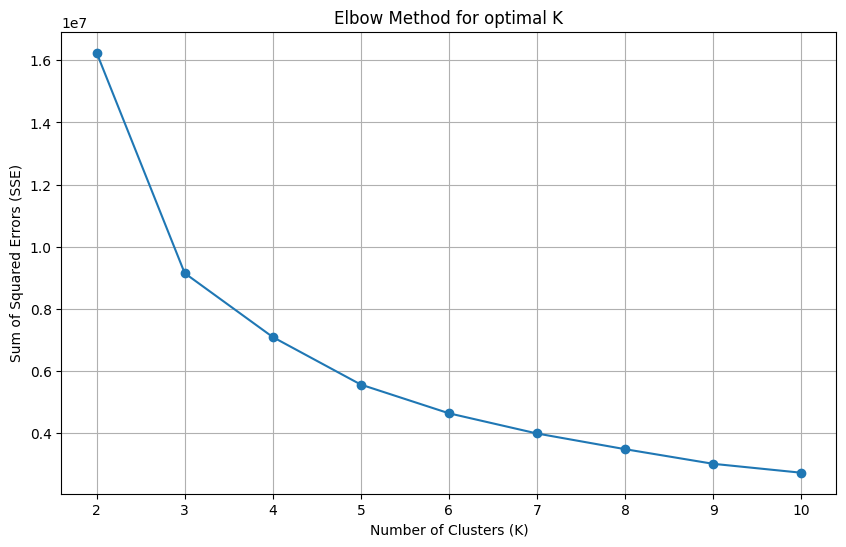

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker="o")
plt.title("Elbow Method for optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(user_dept_df)


Cluster Means (Average tip rate per Cluster):
| cluster   | 0       | 1       |
|:----------|:--------|:--------|
| 0         | 4.06344 | 4.44411 |
| 1         | 10.3488 | 44.7864 |
| 2         | 61.0878 | 17.1033 |
| 3         | 23.1358 | 14.5835 |


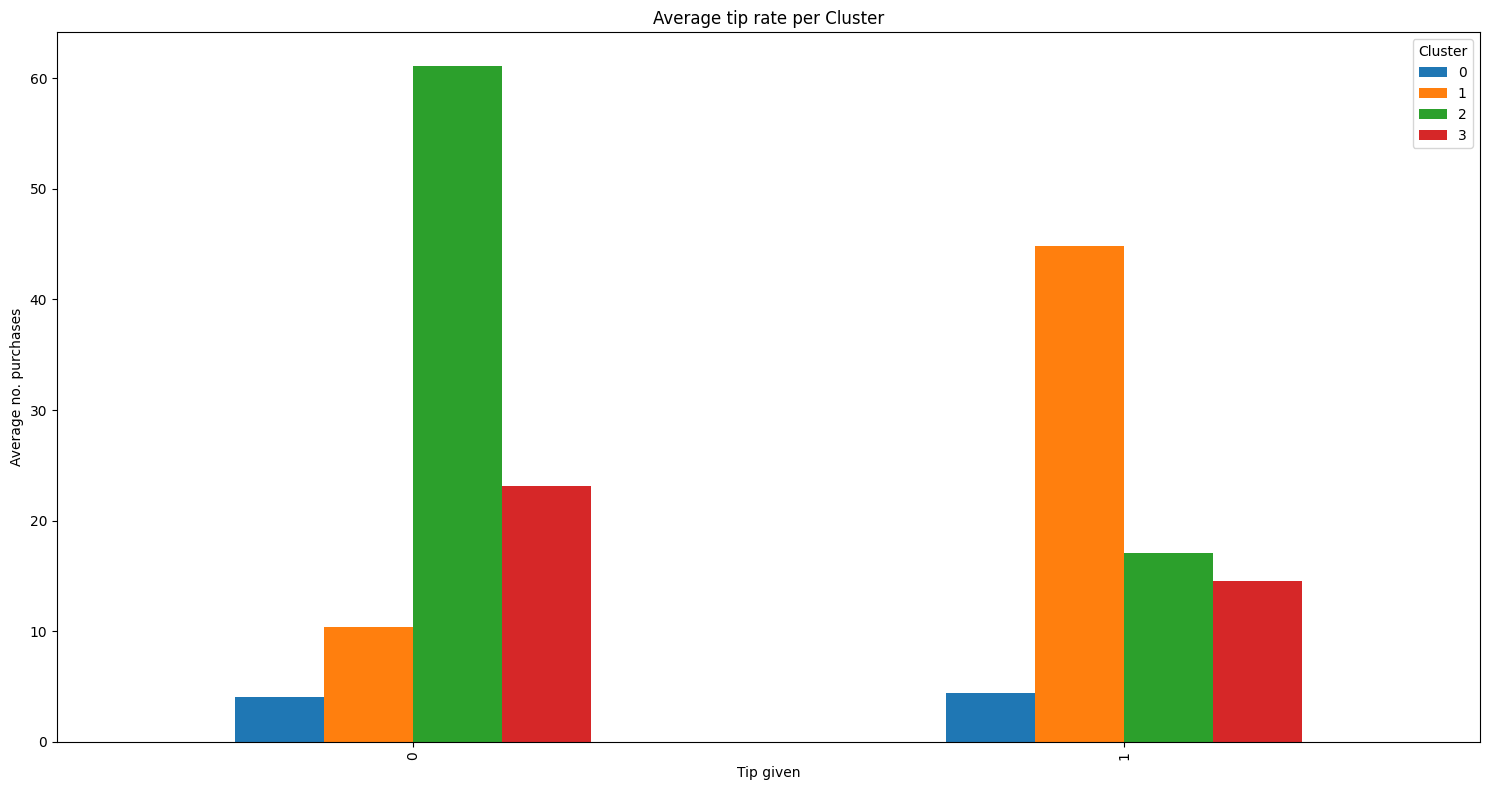

In [ ]:
user_dept_df["cluster"] = clusters

cluster_means = user_dept_df.groupby("cluster").mean()

print("\nCluster Means (Average tip rate per Cluster):")
print(cluster_means.to_markdown(numalign="left", stralign="left"))

cluster_means.drop("cluster", axis=1, errors="ignore").T.plot(kind="bar", figsize=(15, 8))
plt.title("Average tip rate per Cluster")
plt.xlabel("Tip given")
plt.ylabel("Average no. purchases")
plt.xticks(ticks=[False, True])
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()